In [1]:
import nest
import h5py
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

from neuron_response_analysis import (
    SingleNeuronModel, 
    plot_single_response, 
    SpikeTrainSynchronization
)

from neuron_response_analysis import analyze_current_response as analyze_current_response_chen


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:51:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



2025-07-24 16:01:01.781392: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 16:01:01.789875: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 16:01:01.805471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753344061.827213    7465 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753344061.834123    7465 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753344061.856582    7465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# 定义函数

In [2]:
def chen_to_bmtk_mapping_dict(chen_network_path='Allen_V1_param/network_dat.pkl', 
                              bmtk_nodes_path='Allen_V1_param/network/v1_nodes.h5'):
    
    """ 给出chen 111个神经元模板和bmtk 111给神经元模板之间的对应关系 """

    chen_to_bmtk_mapping = {}

    with h5py.File(bmtk_nodes_path, 'r') as f:
        node_type_ids = f['nodes']['v1']['node_type_id'][:]
    with open(chen_network_path, 'rb') as f:
        chen_data = pkl.load(f)

    for chen_neuron_model_template_index in range(111):
        unique_set = list(set(node_type_ids[chen_data['nodes'][chen_neuron_model_template_index]['ids']]))
        # 验证集合元素数量
        if len(unique_set) == 0:
            raise ValueError("未找到bmtk神经元模板")
        elif len(unique_set) == 1:
            chen_to_bmtk_mapping[chen_neuron_model_template_index] = unique_set[0]
        else:
            raise ValueError(f"出现多个bmtk神经元模板与之对应")
            
    return chen_to_bmtk_mapping

In [3]:
def simulate_neuron_response(node_type_id, platform_current,
                             T=1000, dt=0.1, current_start=200, current_end=800):
    node_types = pd.read_csv('Allen_V1_param/network/v1_node_types.csv')
    h5_nodes = h5py.File('Allen_V1_param/network/v1_nodes.h5', 'r')
    model_template = 'glif_psc'
    dynamics_path = f'Allen_V1_param/components/cell_models/nest_models/'+str(node_type_id)+'_glif_psc.json'
    with open(dynamics_path, 'r') as f:
        dynamics_params = json.load(f)
        
    # 创建NEST模型
    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': dt})  # 0.1 ms 时间分辨率

    # 注册模型
    neuron = nest.Create(model_template, 1, params=dynamics_params)
    
    # Step 3: 添加multimeter记录膜电位
    mm = nest.Create("multimeter", params={
        "interval": dt,
        "record_from": ["V_m"]
    })
    nest.Connect(mm, neuron)
    
    # Step 4: 注入平台电流
    stim = nest.Create("dc_generator", params={
        "amplitude": platform_current,  # 单位: pA
        "start": current_start,      # ms
        "stop": current_end       # ms
    })
    nest.Connect(stim, neuron)

    # Step 5: 仿真并记录
    nest.Simulate(T)
    data = nest.GetStatus(mm)[0]["events"]
    time = data["times"]
    voltages = data["V_m"]
    
    spikes = np.zeros(voltages.shape)
    spikes[np.where(np.gradient(voltages)<-5)[0][0::2]-1] = 1
    
    # 根据实际记录的时间点创建对应的电流序列
    current_sequence = np.zeros(len(time), dtype=np.float32)
    current_mask = (time >= current_start) & (time <= current_end)
    current_sequence[current_mask] = platform_current
    
    return time, current_sequence, voltages, spikes

In [4]:
def analyze_current_response_nest(node_type_id, current_amplitudes,
                             T=1000, dt=0.1, current_start=200, current_end=800, plot=False):
    """
    分析神经元在不同电流强度下的响应
    
    参数:
    - neuron_type: 神经元类型
    - current_amplitudes: 电流强度列表
    - model_path: 模型文件路径
    - show_plot: 是否显示图像
    """
    
    n_currents = len(current_amplitudes)
    if plot==True:
        # 创建多子图
        fig, axes = plt.subplots(n_currents + 1, 1, figsize=(10, 2 * (n_currents + 1)), 
                                gridspec_kw={'hspace': 0.3}, plot=False)
        
        # 颜色映射
        colors = plt.cm.viridis(np.linspace(0, 1, n_currents))
        
        # 第一个子图：显示所有电流波形
        time_ref = np.arange(T)  # 参考时间序列
        for i, current_amp in enumerate(current_amplitudes):
            current_waveform = np.zeros(T)
            current_waveform[current_start:current_end] = current_amp
            axes[0].plot(time_ref, current_waveform, color=colors[i], linewidth=2, 
                        label=f'{current_amp} pA')
        
        axes[0].set_ylabel('Current (pA)', fontsize=12)
        axes[0].set_title(f'{node_type_id} neuron response', fontsize=14)
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 存储结果用于分析
    all_results = []
    
    # 对每个电流强度进行仿真
    for i, current_amp in enumerate(current_amplitudes):
        print(f"\n处理电流强度: {current_amp} pA ({i+1}/{n_currents})")
        
        # 运行仿真
        time, current, voltage, spikes = simulate_neuron_response(node_type_id, current_amp,
                                                                  T=T, dt=dt, current_start=current_start, current_end=current_end)
        
        # 存储结果
        spike_count = np.sum(spikes > 0.5)
        firing_rate = spike_count / ( (current_end - current_start) / 1000)
        all_results.append({
            'current': current_amp,
            'spike_count': spike_count,
            'firing_rate': firing_rate,
            'voltage': voltage,
            'spikes': spikes
        })
        
        if plot==True:
            # 绘制到对应子图
            ax = axes[i + 1]
            ax.plot(time, voltage, color='black', linewidth=1.5, label='V_m')
            
            # 添加脉冲标记（在对应时间点的膜电位上画红色竖线）
            spike_indices = np.where(spikes > 0.5)[0]
            for spike_idx in spike_indices:
                spike_voltage = voltage[spike_idx]  # 获取脉冲时刻的膜电位值
                ax.plot(time[spike_idx], spike_voltage, '|k', markersize=10, color='red')
            
            ax.set_ylabel('V_m (mV)', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.text(0.02, 0.98, f'{current_amp} nA\n spike: {spike_count}\n rate: {firing_rate:.1f} Hz', 
                    transform=ax.transAxes, verticalalignment='top', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    if plot==True:
        axes[-1].set_xlabel('时间 (ms)', fontsize=12)
        plt.tight_layout(pad=0.5)
    
    return all_results

def plot_if_curve(neuron_type, results_chen, results_nest, save_dir=None):
    """
    绘制电流-发放频率(I-F)曲线
    
    参数:
    - neuron_type: 神经元类型
    - results: 仿真结果列表
    """
    
    plt.figure(figsize=(6,3))
    
    currents = [r['current'] for r in results_chen]
    firing_rates = [r['firing_rate'] for r in results_chen]
    plt.plot(currents, firing_rates, 'bo-', linewidth=2, markersize=8, color='red', label='Chen')  
    plt.xlabel('input current (nA)', fontsize=12)
    plt.ylabel('firing rate (Hz)', fontsize=12)
    plt.title(f'{neuron_type} I-F curve', fontsize=14)
    
    currents = [r['current'] for r in results_nest]
    firing_rates = [r['firing_rate'] for r in results_nest]
    plt.plot(currents, firing_rates, 'v-', linewidth=2, markersize=8, color='blue', label='NEST')
    
    plt.legend()
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(save_dir + '/' + f'{neuron_type}_if_curve.png', dpi=100)

In [5]:
chen_to_bmtk_mapping = chen_to_bmtk_mapping_dict()

# 单神经元、固定平台电流测试样例

2025-07-24 16:01:09.325649: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


> Recurrent synapses 1
> Input synapses 0


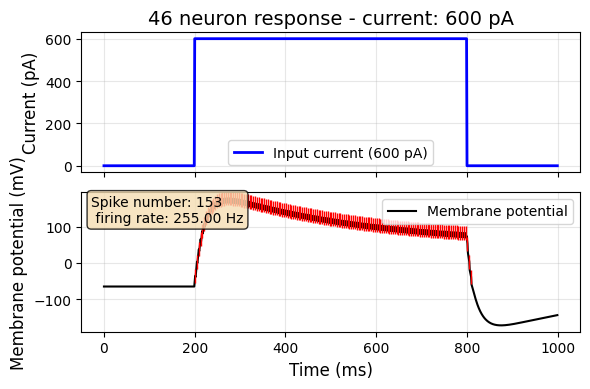

In [6]:
# Chen neuron test
chen_neuron_model_template_index = 46
platform_current = 600
current_start=200
current_end=800
T = 1000

neuron = SingleNeuronModel(chen_neuron_model_template_index,
                           model_path='../GLIF_network/network_dat.pkl', dt=1)
time, current, voltage, spikes = neuron.simulate(
    T, platform_current, current_start, current_end
)
fig = plot_single_response(
    time, current, voltage, spikes, 
    chen_neuron_model_template_index, platform_current
)


Jul 24 16:01:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 16:01:16 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 16:01:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 16:01:16 SimulationManager::run [Info]: 
    Simulation finished.


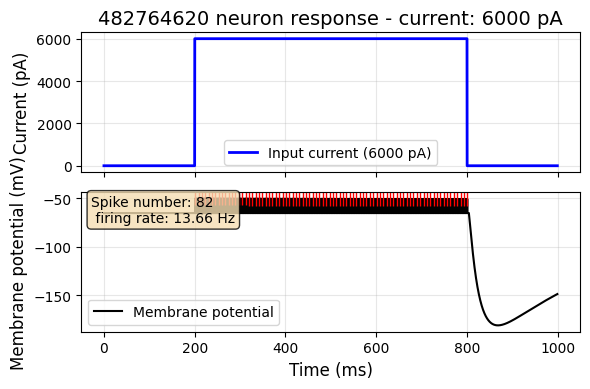

In [7]:
# NEST neuron test
chen_neuron_model_template_index = 46
node_type_id = chen_to_bmtk_mapping[chen_neuron_model_template_index]
platform_current = 6000
current_start=200
current_end=800
T = 1000

time, current, voltage, spikes = simulate_neuron_response(node_type_id=node_type_id, 
                                                          T=T, dt=0.1,
                                                          platform_current=platform_current,
                                                          current_start=current_start,
                                                          current_end=current_end)
fig = plot_single_response(
    time, current, voltage, spikes, 
    node_type_id, platform_current
)

# 单神经元、多电流值测试样例

> Recurrent synapses 1
> Input synapses 0


100%|██████████| 25/25 [02:41<00:00,  6.46s/it]



处理电流强度: 0 pA (1/25)

Jul 24 16:03:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 16:03:58 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 16:03:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 16:03:58 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 16:03:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 16:03:58 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 16:03:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 16:03:58 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 16:03:59 SimulationManager::set_status 

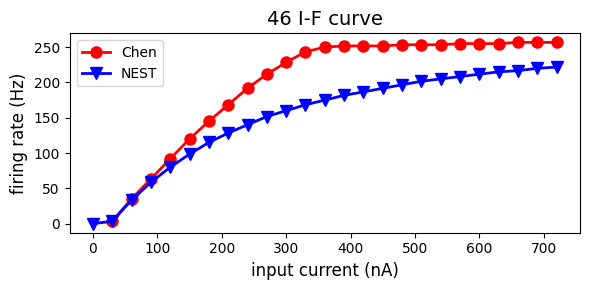

In [ ]:
T = 1000  # ms
current_start = 200
current_end = 800
platform_current = np.arange(0,750,30)
neuron_model_template_index = 46

# # Chen neuron test
neuron = SingleNeuronModel(neuron_model_template_index, model_path='../GLIF_network/network_dat.pkl', dt=1.0)
results_chen = analyze_current_response_chen(
    neuron_model_template_index,
    neuron, T, platform_current, current_start, current_end
)
# NEST neuron test
node_type_id = chen_to_bmtk_mapping[neuron_model_template_index]
results_nest = analyze_current_response_nest(
    node_type_id=node_type_id,
    dt=0.1,
    current_amplitudes=platform_current,
    T=T, current_start=current_start, current_end=current_end
)
# plot I-F curve and save
plot_if_curve(neuron_model_template_index, results_chen, results_nest)

# 循环测试多个神经元、多个电流值

> Recurrent synapses 1
> Input synapses 0


100%|██████████| 25/25 [02:52<00:00,  6.89s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:32:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:32:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:32:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:32:35 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:32:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:32:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:32:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:32:35 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:32:35 SimulationManager::set_status 

100%|██████████| 25/25 [02:45<00:00,  6.60s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:35:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:35:21 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:35:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:35:21 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:35:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:35:21 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:35:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:35:21 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:35:21 SimulationManager::set_status 

100%|██████████| 25/25 [02:37<00:00,  6.29s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:38:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:38:01 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:38:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:38:01 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:38:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:38:01 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:38:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:38:01 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:38:01 SimulationManager::set_status 

100%|██████████| 25/25 [02:38<00:00,  6.34s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:40:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:40:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:40:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:40:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:40:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:40:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:40:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:40:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:40:41 SimulationManager::set_status 

100%|██████████| 25/25 [02:40<00:00,  6.42s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:43:23 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:43:23 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:43:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:43:23 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:43:23 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:43:23 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:43:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:43:23 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:43:23 SimulationManager::set_status 

100%|██████████| 25/25 [02:37<00:00,  6.29s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:46:02 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:46:02 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:46:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:46:02 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:46:02 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:46:02 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:46:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:46:02 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:46:02 SimulationManager::set_status 

100%|██████████| 25/25 [02:37<00:00,  6.30s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:48:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:48:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:48:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:48:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:48:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:48:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:48:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:48:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:48:41 SimulationManager::set_status 

100%|██████████| 25/25 [02:38<00:00,  6.35s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:51:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:51:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:51:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:51:22 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:51:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:51:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:51:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:51:22 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:51:22 SimulationManager::set_status 

100%|██████████| 25/25 [02:37<00:00,  6.29s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:54:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:54:01 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:54:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:54:01 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:54:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:54:01 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:54:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:54:01 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:54:01 SimulationManager::set_status 

100%|██████████| 25/25 [02:38<00:00,  6.33s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:56:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:56:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:56:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:56:40 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:56:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:56:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:56:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:56:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:56:41 SimulationManager::set_status 

100%|██████████| 25/25 [02:44<00:00,  6.57s/it]



处理电流强度: 0 pA (1/25)

Jul 24 20:59:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:59:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:59:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:59:26 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 20:59:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 20:59:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 20:59:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 20:59:26 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 20:59:26 SimulationManager::set_status 

100%|██████████| 25/25 [02:39<00:00,  6.37s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:02:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:02:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:02:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:02:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:02:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:02:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:02:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:02:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:02:07 SimulationManager::set_status 

100%|██████████| 25/25 [02:37<00:00,  6.28s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:04:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:04:46 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:04:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:04:46 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:04:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:04:46 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:04:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:04:46 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:04:46 SimulationManager::set_status 

100%|██████████| 25/25 [02:38<00:00,  6.32s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:07:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:07:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:07:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:07:26 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:07:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:07:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:07:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:07:26 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:07:26 SimulationManager::set_status 

100%|██████████| 25/25 [02:39<00:00,  6.38s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:10:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:10:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:10:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:10:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:10:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:10:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:10:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:10:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:10:07 SimulationManager::set_status 

100%|██████████| 25/25 [02:34<00:00,  6.17s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:12:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:12:43 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:12:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:12:43 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:12:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:12:43 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:12:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:12:43 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:12:43 SimulationManager::set_status 

100%|██████████| 25/25 [02:33<00:00,  6.15s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:15:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:15:18 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:15:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:15:18 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:15:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:15:18 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:15:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:15:18 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:15:18 SimulationManager::set_status 

100%|██████████| 25/25 [02:33<00:00,  6.14s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:17:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:17:53 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:17:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:17:53 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:17:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:17:53 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:17:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:17:53 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:17:53 SimulationManager::set_status 

100%|██████████| 25/25 [02:39<00:00,  6.37s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:20:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:20:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:20:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:20:35 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:20:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:20:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:20:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:20:35 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:20:35 SimulationManager::set_status 

100%|██████████| 25/25 [02:40<00:00,  6.43s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:23:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:23:17 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:23:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:23:17 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:23:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:23:18 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:23:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:23:18 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:23:18 SimulationManager::set_status 

100%|██████████| 25/25 [02:39<00:00,  6.40s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:25:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:25:59 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:25:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:25:59 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:25:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:25:59 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:25:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:25:59 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:25:59 SimulationManager::set_status 

100%|██████████| 25/25 [02:48<00:00,  6.72s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:28:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:28:49 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:28:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:28:49 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:28:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:28:49 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:28:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:28:49 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:28:49 SimulationManager::set_status 

100%|██████████| 25/25 [02:33<00:00,  6.14s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:31:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:31:25 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:31:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:31:25 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:31:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:31:25 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:31:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:31:25 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:31:25 SimulationManager::set_status 

100%|██████████| 25/25 [02:46<00:00,  6.64s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:34:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:34:12 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:34:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:34:12 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:34:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:34:12 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:34:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:34:12 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:34:12 SimulationManager::set_status 

100%|██████████| 25/25 [02:31<00:00,  6.08s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:36:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:36:46 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:36:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:36:46 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:36:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:36:46 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:36:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:36:46 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:36:46 SimulationManager::set_status 

100%|██████████| 25/25 [02:31<00:00,  6.07s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:39:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:39:19 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:39:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:39:19 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:39:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:39:19 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:39:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:39:19 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:39:19 SimulationManager::set_status 

100%|██████████| 25/25 [02:33<00:00,  6.13s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:41:54 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:41:54 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:41:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:41:54 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:41:54 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:41:54 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:41:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:41:54 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:41:54 SimulationManager::set_status 

100%|██████████| 25/25 [02:33<00:00,  6.13s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:44:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:44:29 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:44:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:44:29 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:44:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:44:29 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:44:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:44:29 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:44:29 SimulationManager::set_status 

100%|██████████| 25/25 [02:33<00:00,  6.15s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:47:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:47:04 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:47:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:47:04 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:47:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:47:04 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:47:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:47:04 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:47:04 SimulationManager::set_status 

100%|██████████| 25/25 [02:31<00:00,  6.06s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:49:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:49:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:49:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:49:37 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:49:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:49:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:49:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:49:37 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:49:37 SimulationManager::set_status 

100%|██████████| 25/25 [02:26<00:00,  5.85s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:52:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:52:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:52:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:52:05 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:52:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:52:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:52:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:52:05 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:52:05 SimulationManager::set_status 

100%|██████████| 25/25 [02:29<00:00,  5.99s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:54:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:54:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:54:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:54:37 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:54:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:54:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:54:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:54:37 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:54:37 SimulationManager::set_status 

100%|██████████| 25/25 [02:27<00:00,  5.92s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:57:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:57:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:57:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:57:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:57:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:57:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:57:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:57:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:57:07 SimulationManager::set_status 

100%|██████████| 25/25 [02:31<00:00,  6.05s/it]



处理电流强度: 0 pA (1/25)

Jul 24 21:59:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:59:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:59:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:59:40 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 21:59:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 21:59:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 21:59:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 21:59:40 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 21:59:40 SimulationManager::set_status 

100%|██████████| 25/25 [02:29<00:00,  5.97s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:02:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:02:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:02:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:02:10 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:02:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:02:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:02:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:02:10 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:02:11 SimulationManager::set_status 

100%|██████████| 25/25 [02:28<00:00,  5.95s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:04:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:04:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:04:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:04:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:04:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:04:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:04:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:04:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:04:41 SimulationManager::set_status 

100%|██████████| 25/25 [02:26<00:00,  5.87s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:07:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:07:09 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:07:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:07:09 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:07:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:07:09 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:07:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:07:09 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:07:10 SimulationManager::set_status 

100%|██████████| 25/25 [02:30<00:00,  6.03s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:09:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:09:42 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:09:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:09:42 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:09:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:09:42 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:09:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:09:42 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:09:42 SimulationManager::set_status 

100%|██████████| 25/25 [02:27<00:00,  5.90s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:12:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:12:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:12:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:12:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:12:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:12:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:12:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:12:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:12:11 SimulationManager::set_status 

100%|██████████| 25/25 [02:28<00:00,  5.94s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:14:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:14:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:14:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:14:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:14:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:14:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:14:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:14:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:14:41 SimulationManager::set_status 

100%|██████████| 25/25 [02:27<00:00,  5.90s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:17:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:17:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:17:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:17:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:17:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:17:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:17:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:17:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:17:11 SimulationManager::set_status 

100%|██████████| 25/25 [02:29<00:00,  5.98s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:19:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:19:42 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:19:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:19:42 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:19:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:19:42 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:19:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:19:42 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:19:42 SimulationManager::set_status 

100%|██████████| 25/25 [02:27<00:00,  5.92s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:22:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:22:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:22:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:22:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:22:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:22:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:22:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:22:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:22:11 SimulationManager::set_status 

100%|██████████| 25/25 [02:26<00:00,  5.85s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:24:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:24:39 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:24:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:24:39 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:24:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:24:39 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:24:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:24:39 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:24:39 SimulationManager::set_status 

100%|██████████| 25/25 [02:27<00:00,  5.88s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:27:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:27:08 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:27:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:27:08 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:27:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:27:08 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:27:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:27:08 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:27:08 SimulationManager::set_status 

100%|██████████| 25/25 [02:30<00:00,  6.02s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:29:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:29:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:29:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:29:40 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:29:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:29:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:29:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:29:40 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:29:40 SimulationManager::set_status 

100%|██████████| 25/25 [02:29<00:00,  5.99s/it]



处理电流强度: 0 pA (1/25)

Jul 24 22:32:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:32:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:32:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:32:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 22:32:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 22:32:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 22:32:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 22:32:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 22:32:11 SimulationManager::set_status 

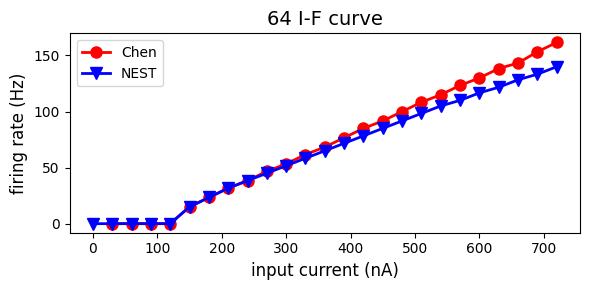

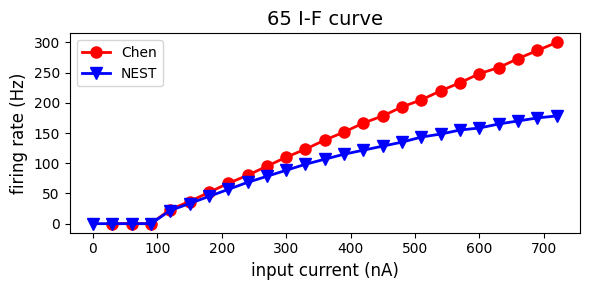

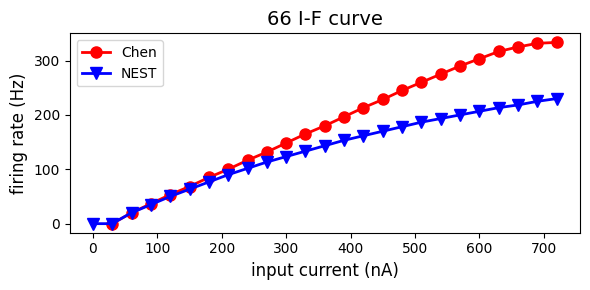

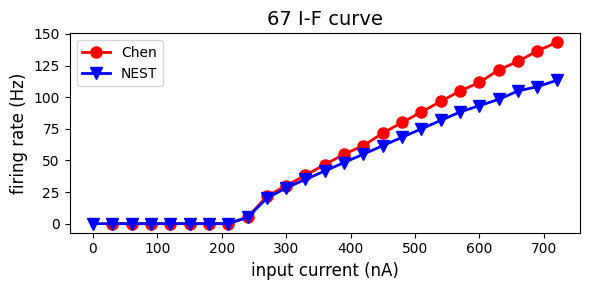

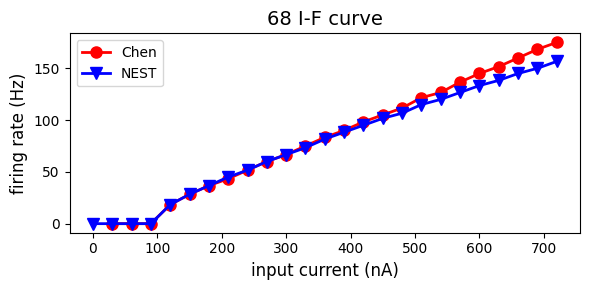

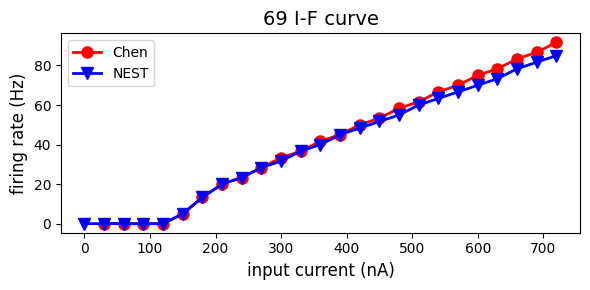

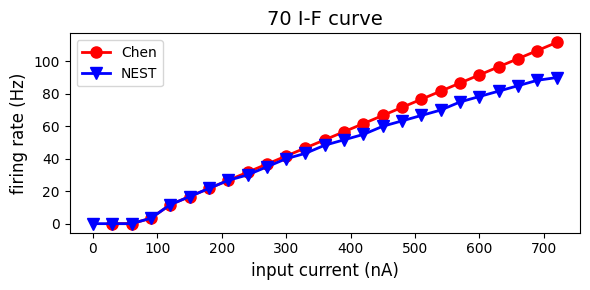

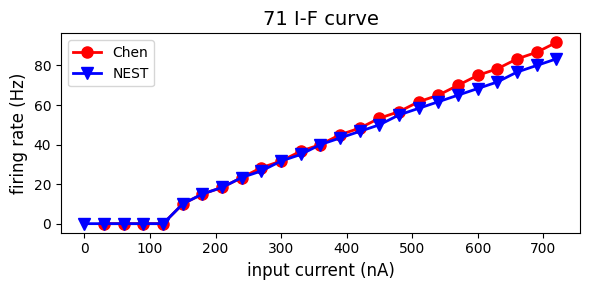

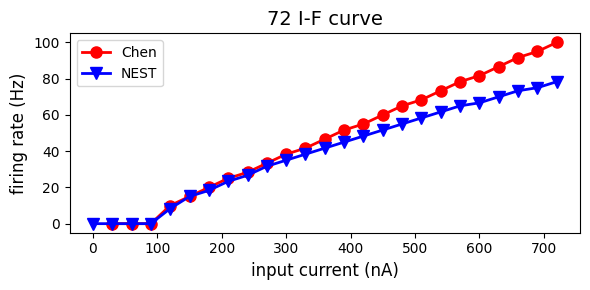

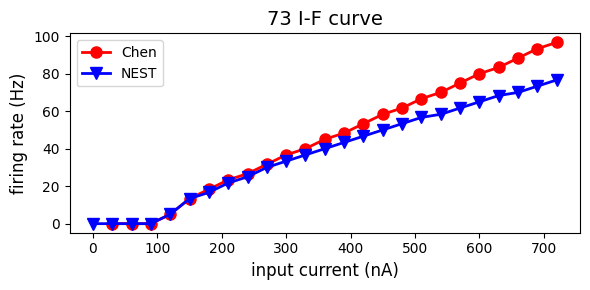

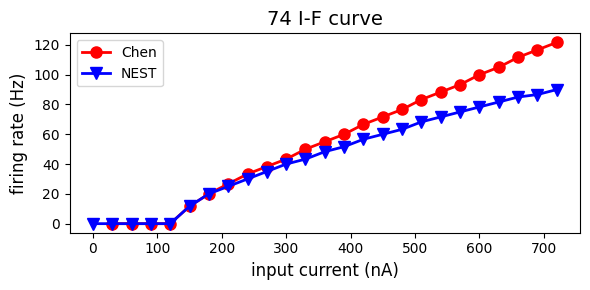

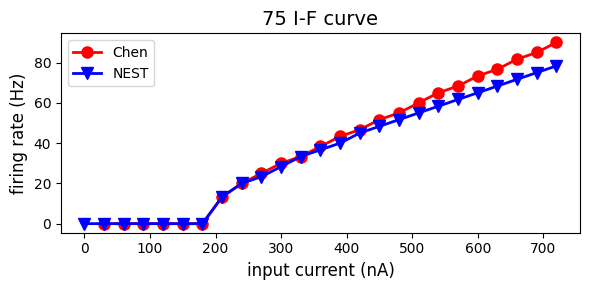

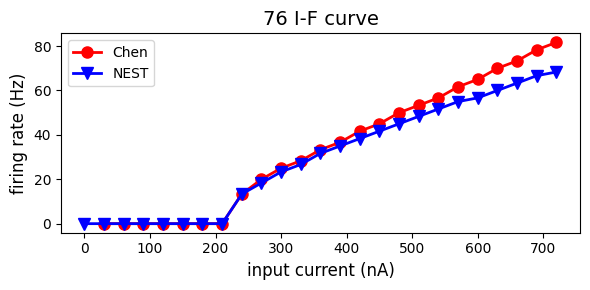

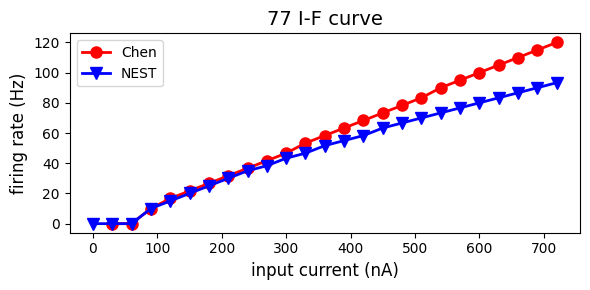

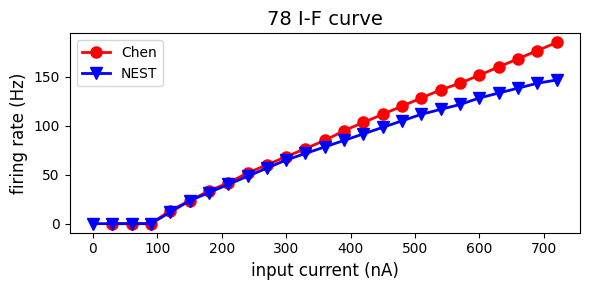

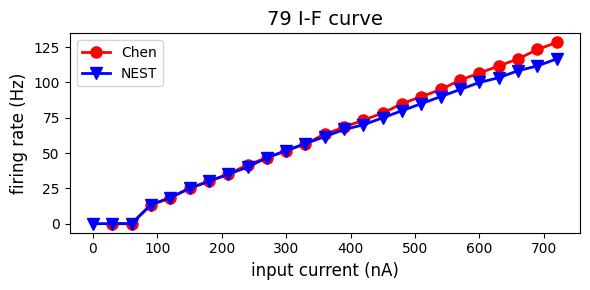

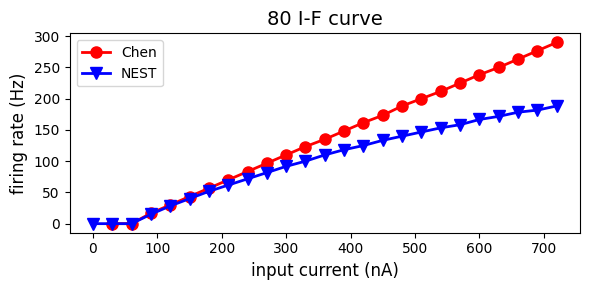

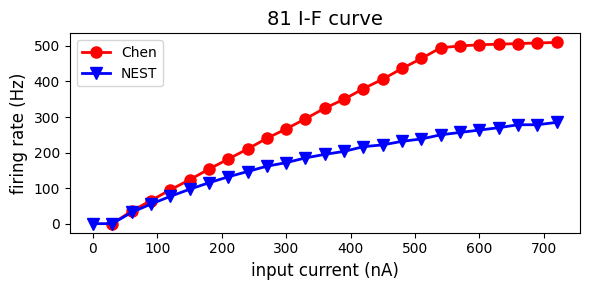

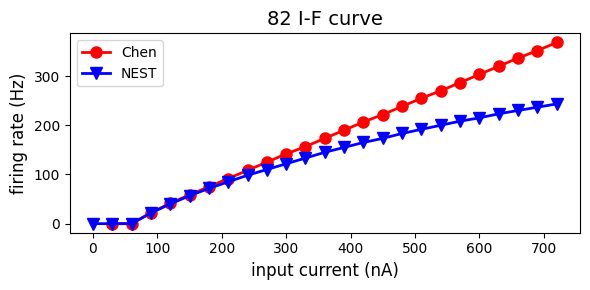

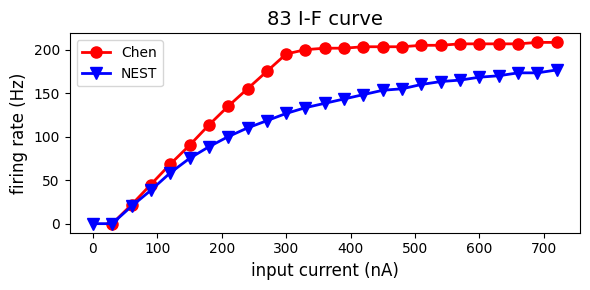

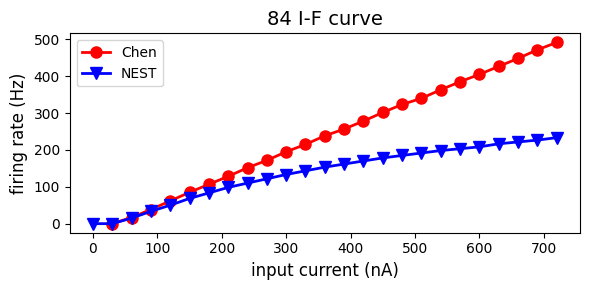

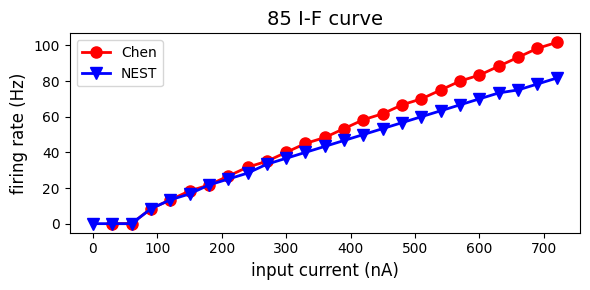

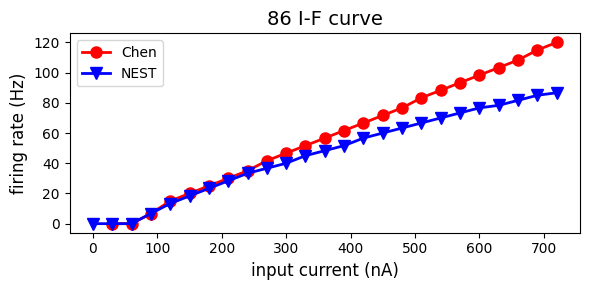

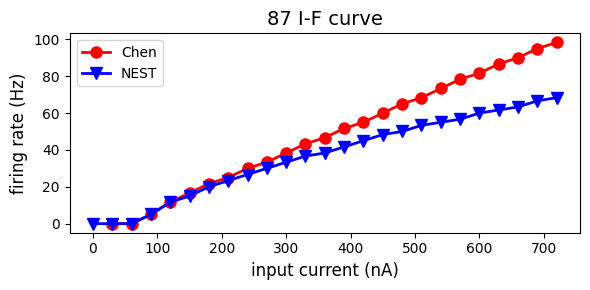

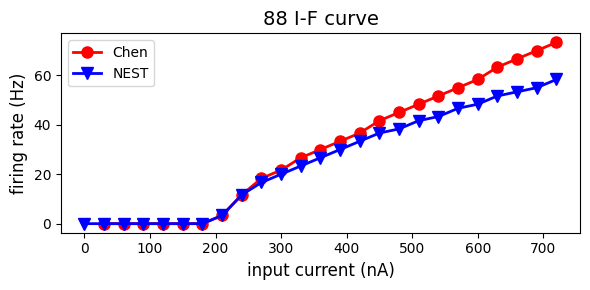

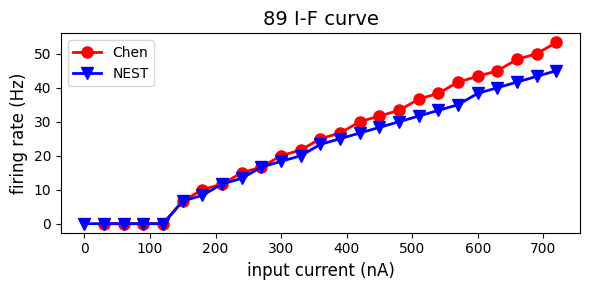

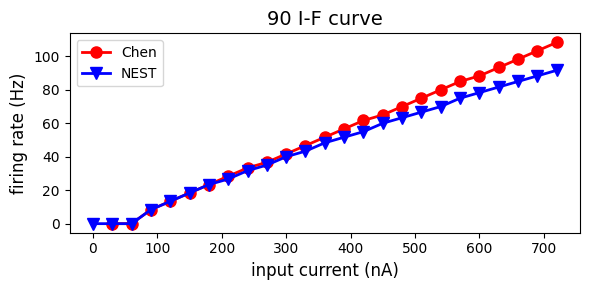

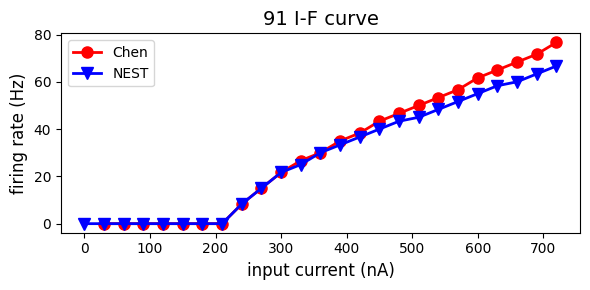

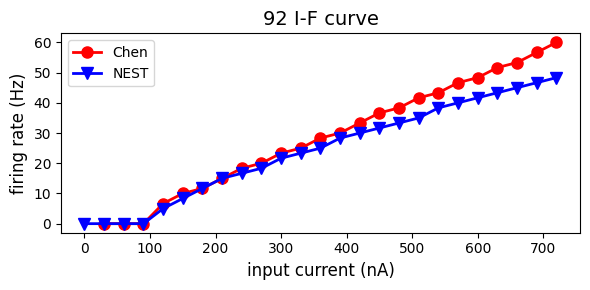

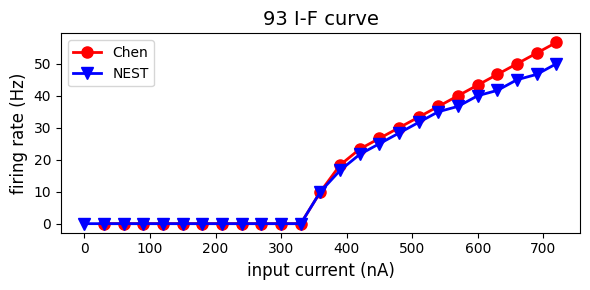

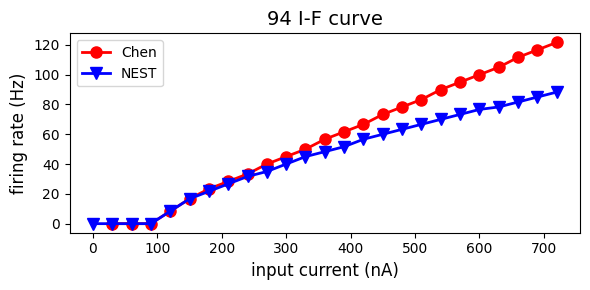

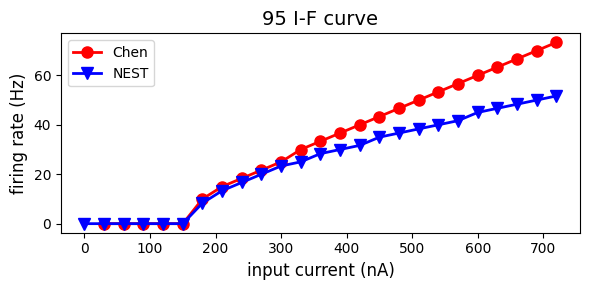

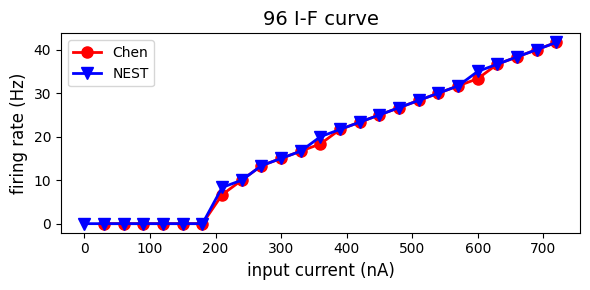

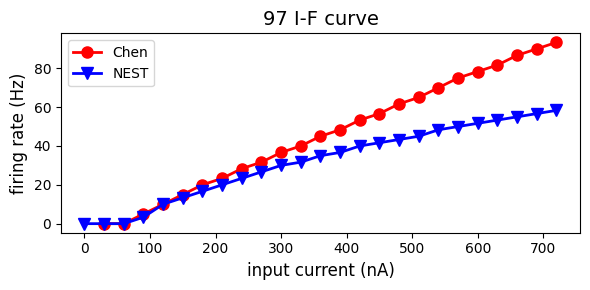

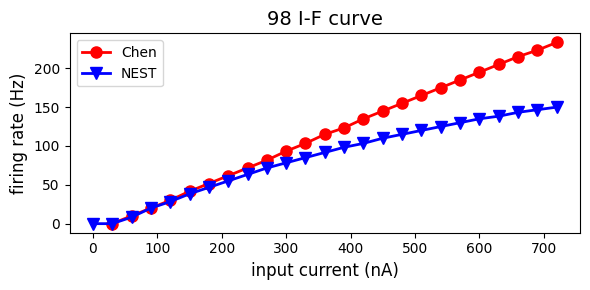

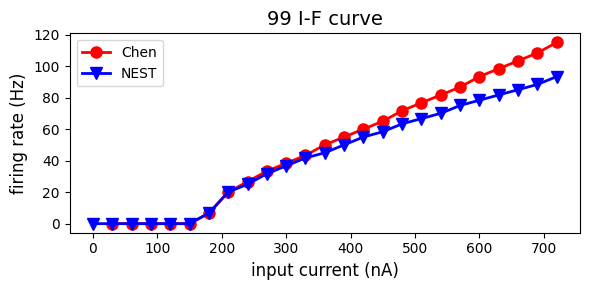

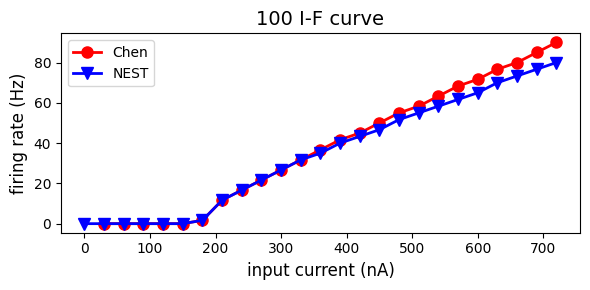

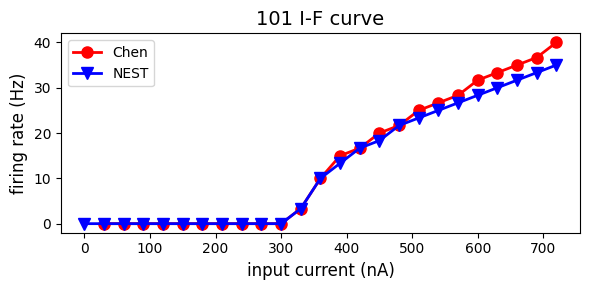

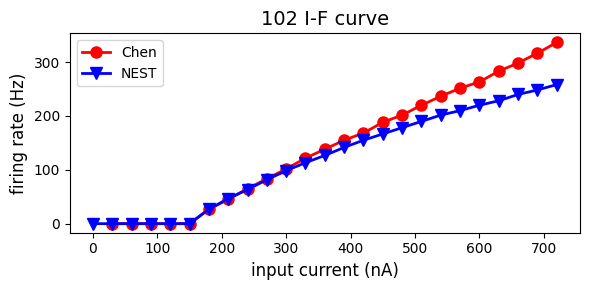

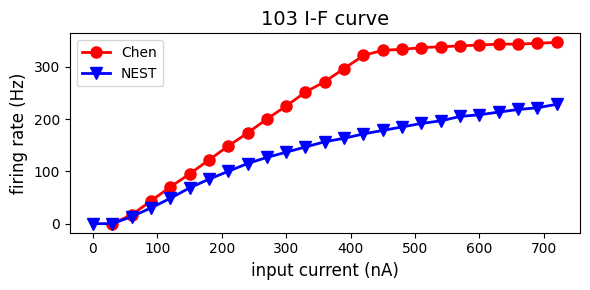

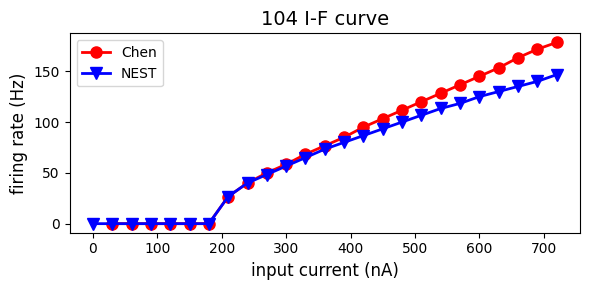

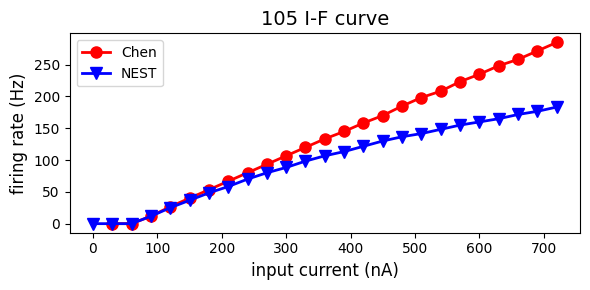

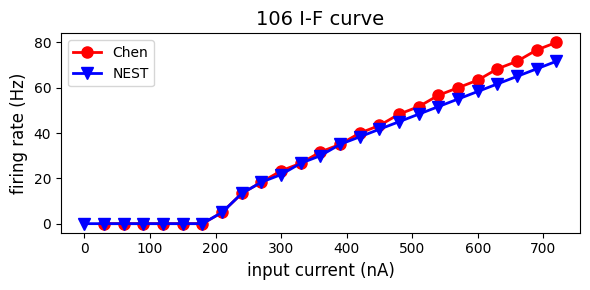

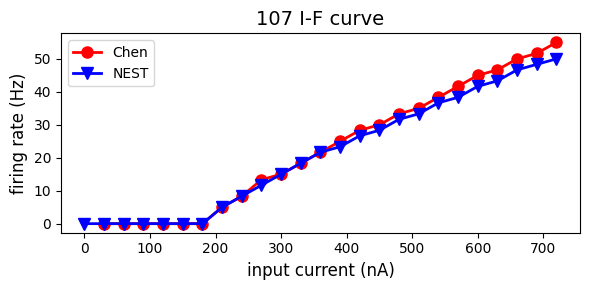

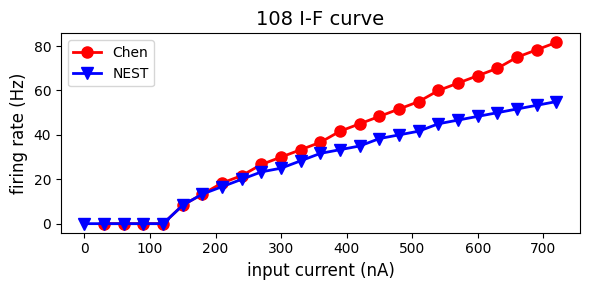

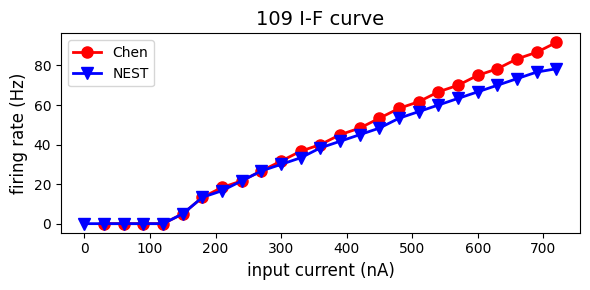

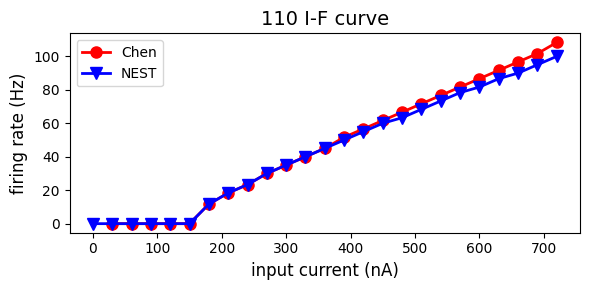

In [ ]:
# 循环测试多个神经元，并保存结果。保存rate coding 结果、保存用于timing analysis的文件
T = 1000  # ms
current_start = 200
current_end = 800
platform_current = np.arange(0,750,30)
    
for neuron_model_template_index in range(111):
    cch_peak_amplitude_list = []
    cch_fwhm_list = []
    mi_normalized_list = []
    tolerance_2ms_list = []
    tolerance_5ms_list = []
    # Chen neuron test
    neuron = SingleNeuronModel(neuron_model_template_index, model_path='../GLIF_network/network_dat.pkl')
    results_chen = analyze_current_response_chen(
        neuron_model_template_index,
        neuron, T, platform_current, current_start, current_end
    )
    # NEST neuron test
    node_type_id = chen_to_bmtk_mapping[neuron_model_template_index]
    results_nest = analyze_current_response_nest(
        node_type_id=node_type_id,
        dt=0.1,
        current_amplitudes=platform_current,
        T=T, current_start=current_start, current_end=current_end
    )
    # plot I-F curve and save
    plot_if_curve(neuron_model_template_index, results_chen, results_nest, save_dir='single_neuron_compare')
    
    sync_analyzer = SpikeTrainSynchronization(dt=1.0)
    for i in range(len(results_chen)):
        results = sync_analyzer.comprehensive_analysis(results_chen[i]['spikes'][:999], 
                                                       results_nest[i]['spikes'].reshape(999,10).sum(axis=1),
                                                       plot_synchronization=False)
        cch_peak_amplitude_list.append(results['cch']['peak_amplitude']) 
        cch_fwhm_list.append(results['cch']['fwhm'])
        mi_normalized_list.append(results['mutual_information']['mi_normalized'])
        tolerance_2ms_list.append(results['coincidence_rate']['tolerance_2ms'][-1])
        tolerance_5ms_list.append(results['coincidence_rate']['tolerance_5ms'][-1])

    cch_peak_amplitude = np.array(cch_peak_amplitude_list)
    cch_fwhm = np.array(cch_fwhm_list)
    mi_normalized = np.array(mi_normalized_list)
    tolerance_2ms = np.array(tolerance_2ms_list)
    tolerance_5ms = np.array(tolerance_5ms_list)
    timing_index = np.vstack((cch_peak_amplitude, cch_fwhm, mi_normalized, tolerance_2ms, tolerance_5ms))
    np.save('single_neuron_compare/timing_index_'+str(neuron_model_template_index)+'.npy', timing_index)


处理电流强度: 0 pA (1/25)

Jul 24 23:46:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:31 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:31 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:31 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:31 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:31 SimulationManager::set_status 

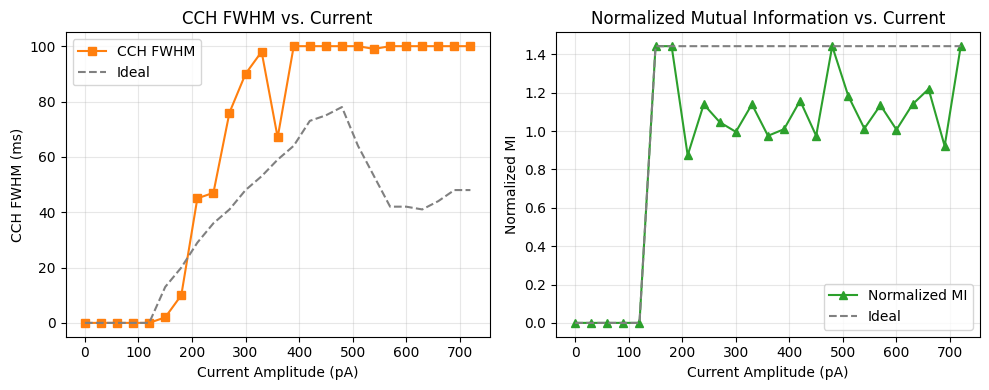


处理电流强度: 0 pA (1/25)

Jul 24 23:46:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:32 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:32 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:32 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:32 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:32 SimulationManager::set_status 

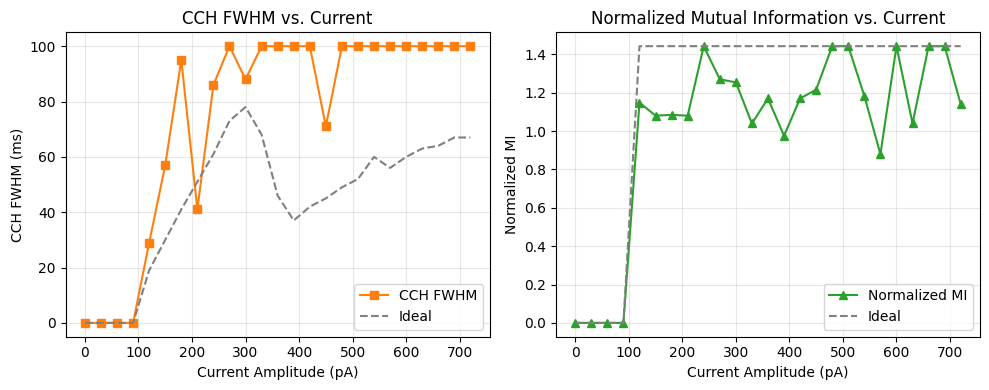


处理电流强度: 0 pA (1/25)

Jul 24 23:46:34 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:34 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:34 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:34 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:34 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:34 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:34 SimulationManager::set_status 

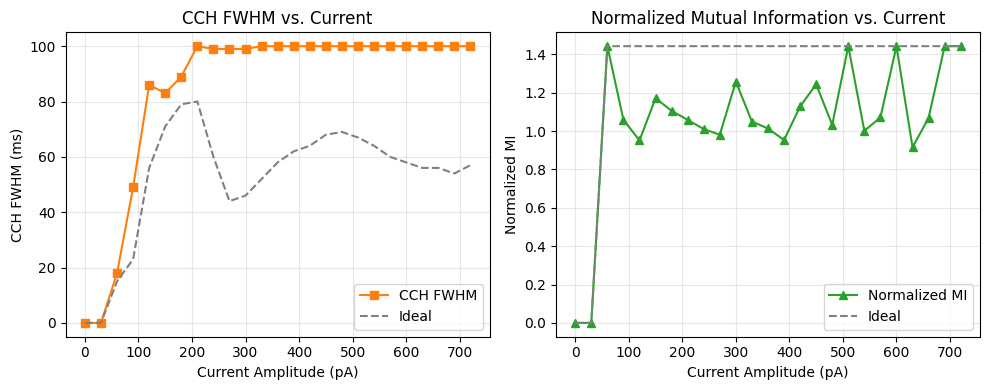


处理电流强度: 0 pA (1/25)

Jul 24 23:46:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:35 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:35 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:35 SimulationManager::set_status 

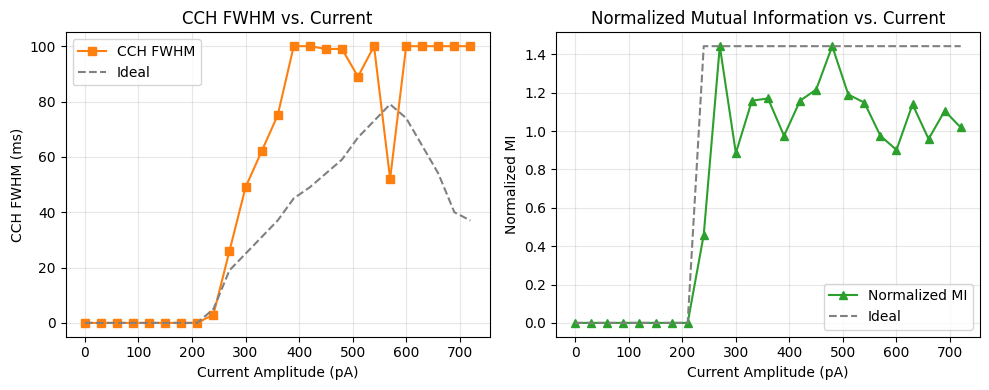


处理电流强度: 0 pA (1/25)

Jul 24 23:46:36 SimulationManager::set_status [Info]: 
    
处理电流强度: 30 pA (2/25)
Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:36 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:36 SimulationManager::run [Info]: 
    Simulation finished.

Jul 24 23:46:36 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:36 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:36 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:36 SimulationManager::set_status 

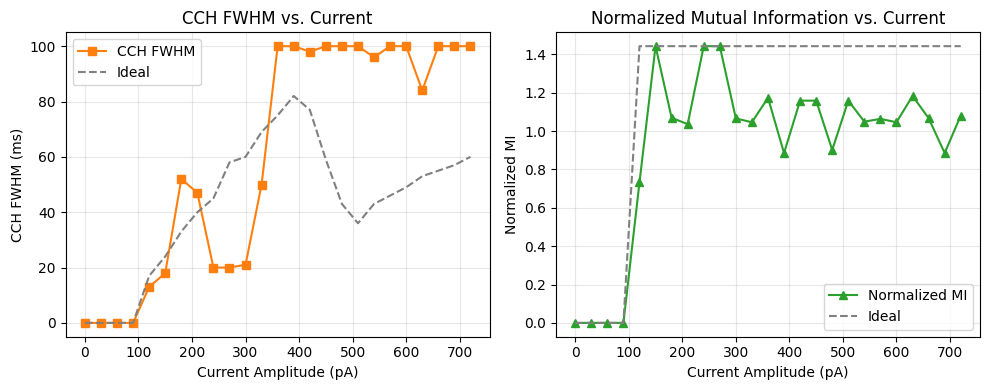


处理电流强度: 0 pA (1/25)

Jul 24 23:46:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:37 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:37 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:37 SimulationManager::set_status 

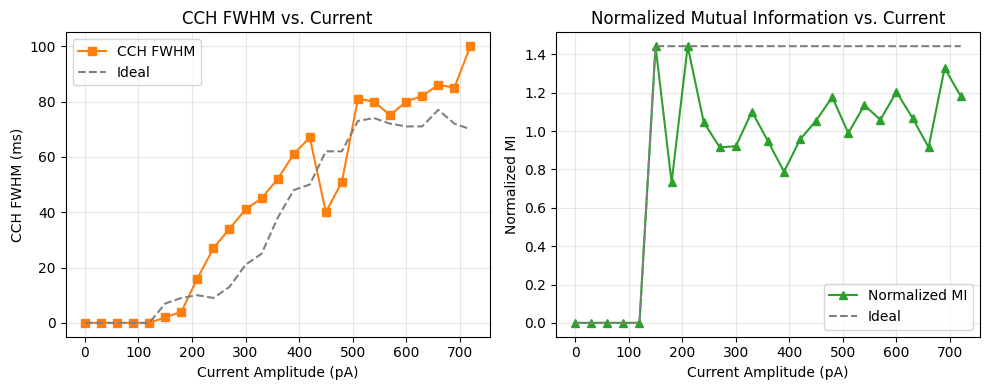


处理电流强度: 0 pA (1/25)

Jul 24 23:46:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:39 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:39 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:39 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:39 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:39 SimulationManager::set_status 

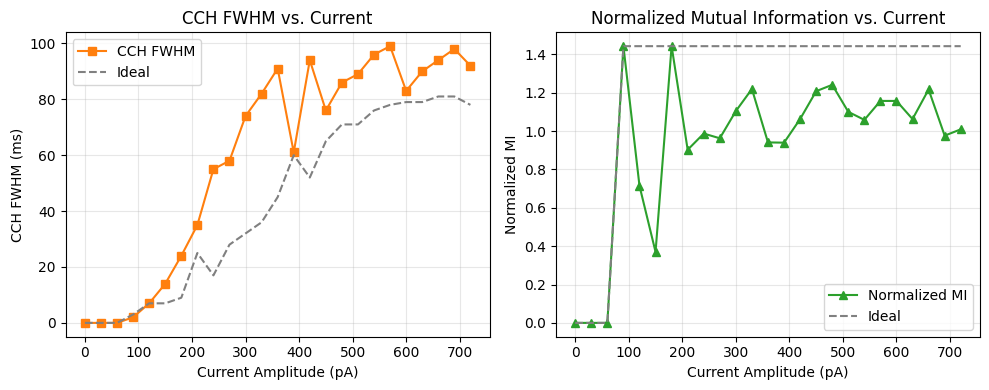


处理电流强度: 0 pA (1/25)

Jul 24 23:46:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:40 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:40 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:40 SimulationManager::set_status 

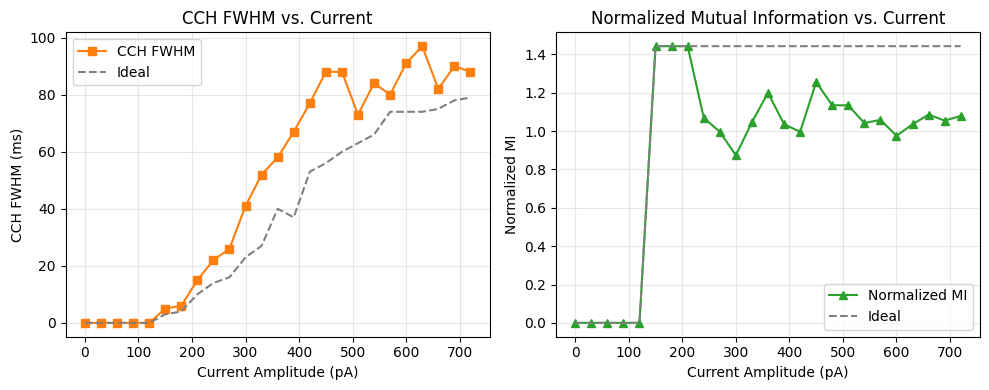


处理电流强度: 0 pA (1/25)

Jul 24 23:46:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:41 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:41 SimulationManager::set_status 

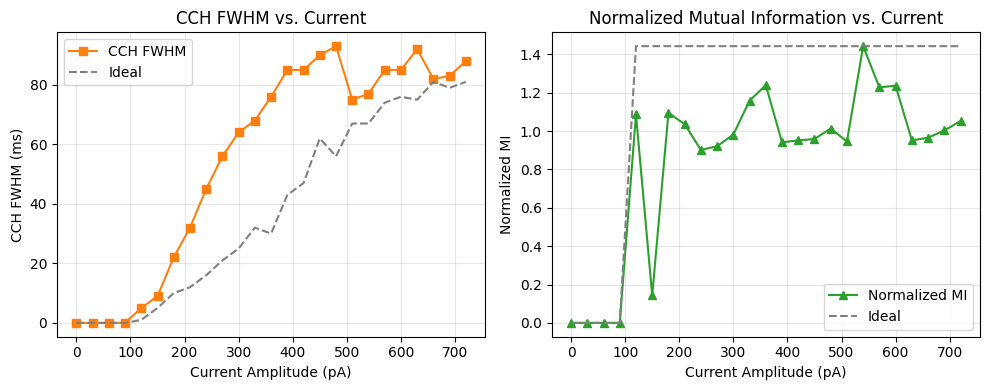


处理电流强度: 0 pA (1/25)

Jul 24 23:46:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:42 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:42 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:42 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:42 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:43 SimulationManager::set_status 

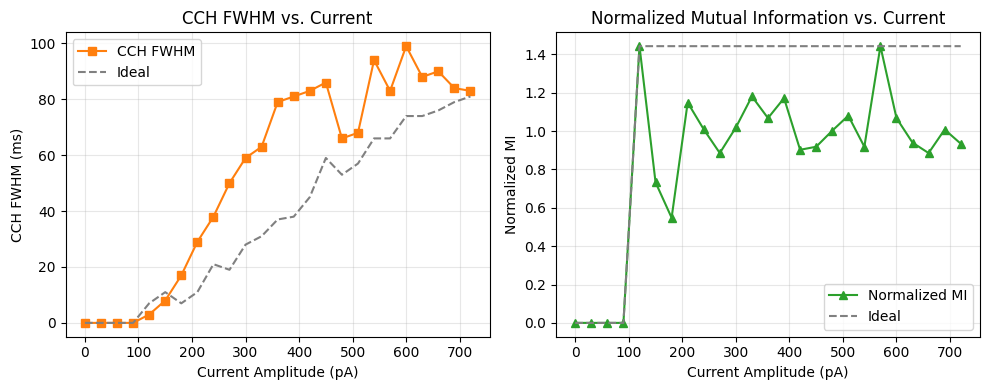


处理电流强度: 0 pA (1/25)

Jul 24 23:46:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:44 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:44 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:44 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:44 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:44 SimulationManager::set_status 

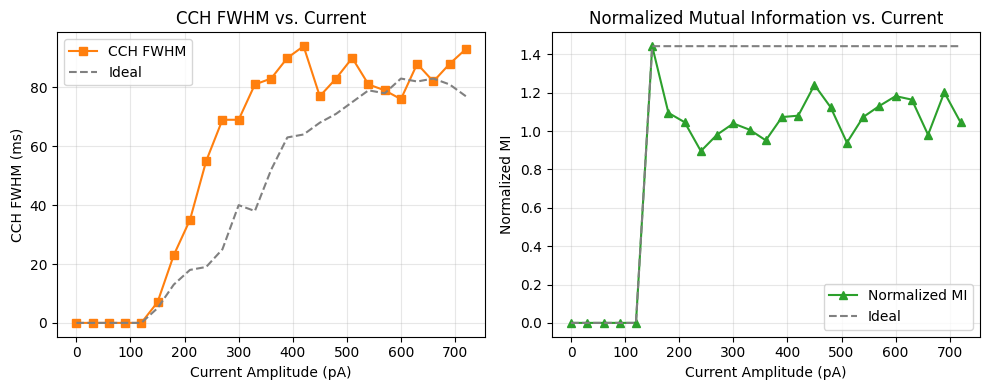


处理电流强度: 0 pA (1/25)

Jul 24 23:46:45 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:45 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:45 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:45 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:45 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:45 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:45 SimulationManager::set_status 

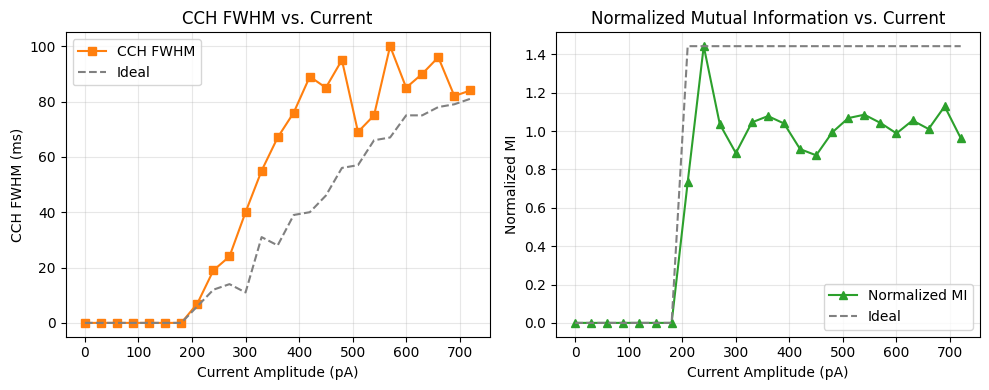


处理电流强度: 0 pA (1/25)

Jul 24 23:46:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:46 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:46 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:46 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:46 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:46 SimulationManager::set_status 

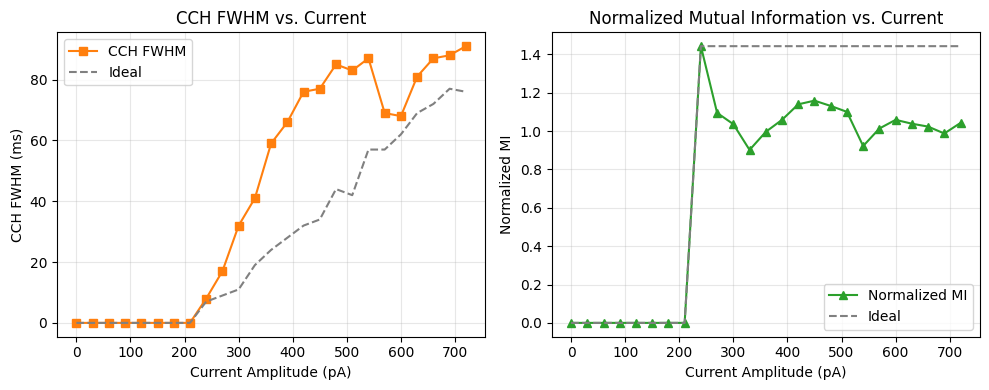


处理电流强度: 0 pA (1/25)

Jul 24 23:46:48 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:48 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:48 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:48 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:48 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:48 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:48 SimulationManager::set_status 

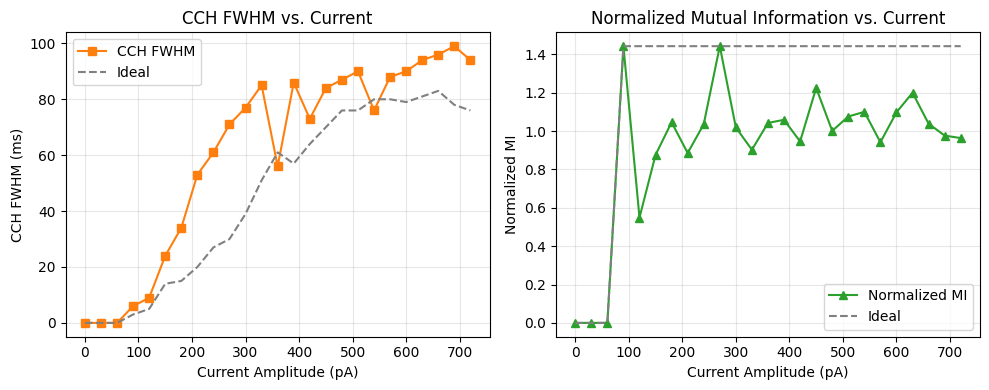


处理电流强度: 0 pA (1/25)

Jul 24 23:46:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:49 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:49 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:49 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:49 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:49 SimulationManager::set_status 

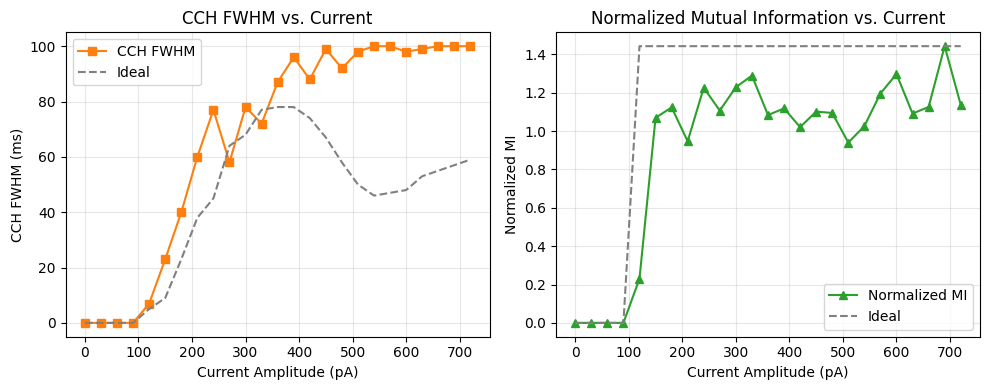


处理电流强度: 0 pA (1/25)

Jul 24 23:46:50 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:50 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:50 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:50 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:50 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:50 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:50 SimulationManager::set_status 

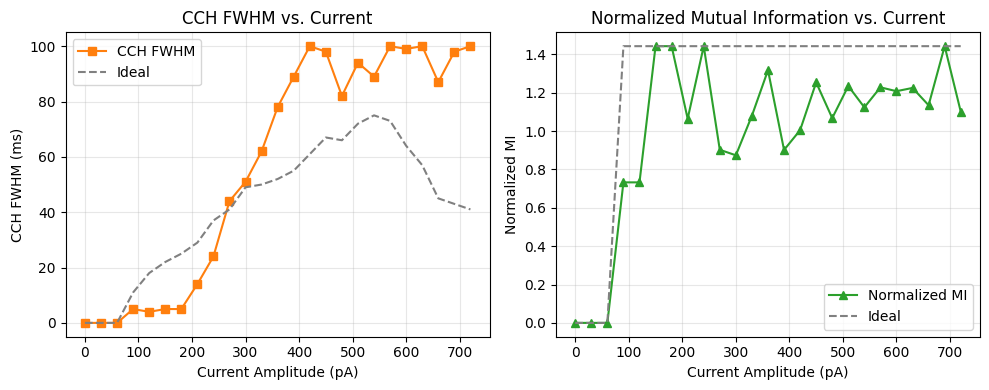


处理电流强度: 0 pA (1/25)

Jul 24 23:46:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:51 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:51 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:51 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:51 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:51 SimulationManager::set_status 

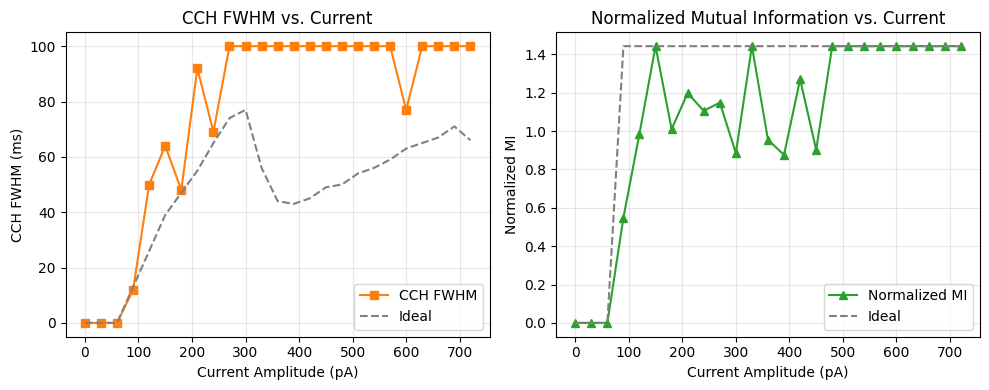


处理电流强度: 0 pA (1/25)

Jul 24 23:46:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:53 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:53 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:53 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:53 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:53 SimulationManager::set_status 

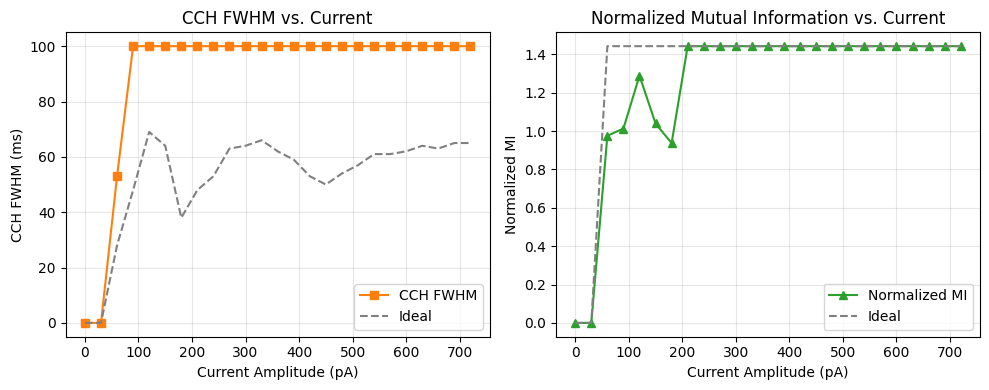


处理电流强度: 0 pA (1/25)

Jul 24 23:46:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:55 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:55 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:55 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:55 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:55 SimulationManager::set_status 

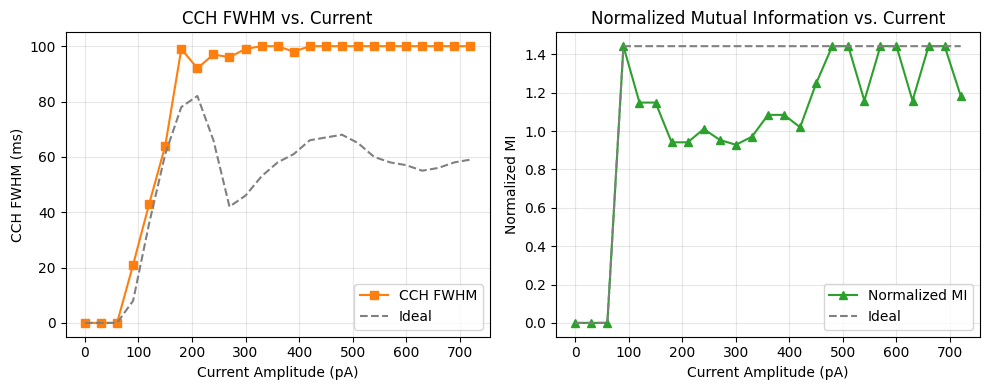


处理电流强度: 0 pA (1/25)

Jul 24 23:46:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:56 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:56 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:56 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:56 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:56 SimulationManager::set_status 

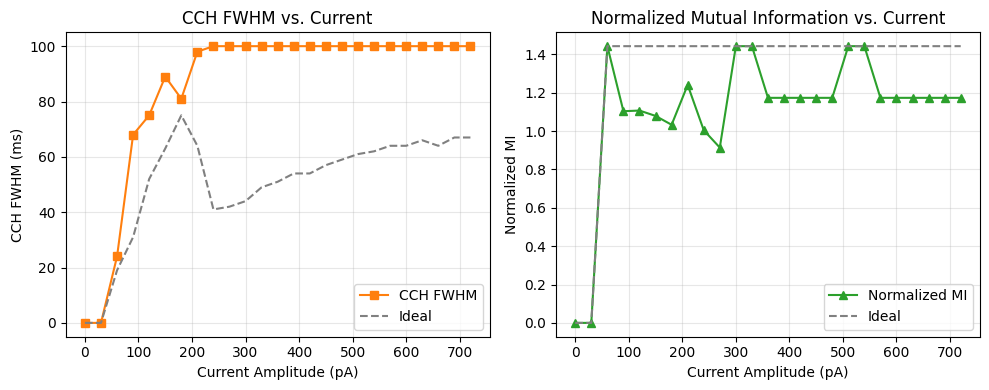


处理电流强度: 0 pA (1/25)

Jul 24 23:46:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:57 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:57 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:57 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:57 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)


处理电流强度: 90 pA (4/25)
Jul 24 23:46:57 Simulati

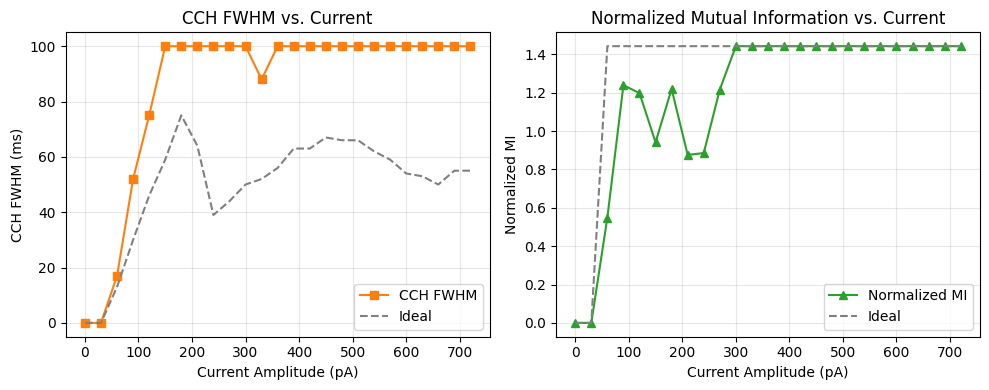


处理电流强度: 0 pA (1/25)

Jul 24 23:46:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:59 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:59 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:46:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:46:59 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:46:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:46:59 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:46:59 SimulationManager::set_status 

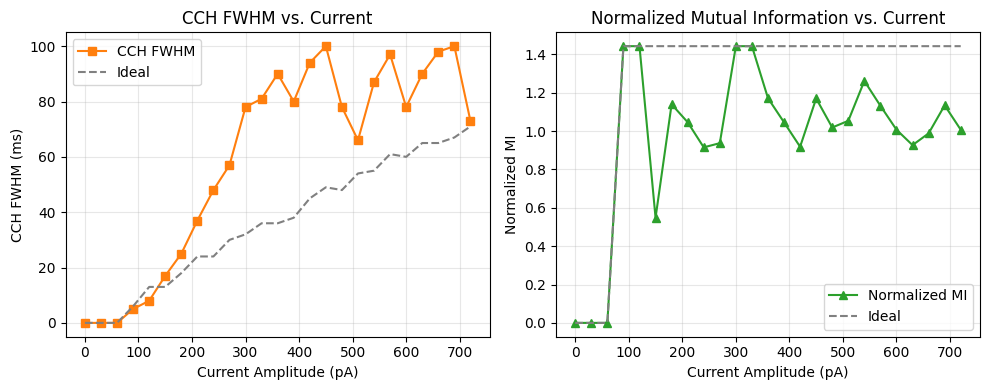


处理电流强度: 0 pA (1/25)

Jul 24 23:47:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:00 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:00 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:00 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:00 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:00 SimulationManager::set_status 

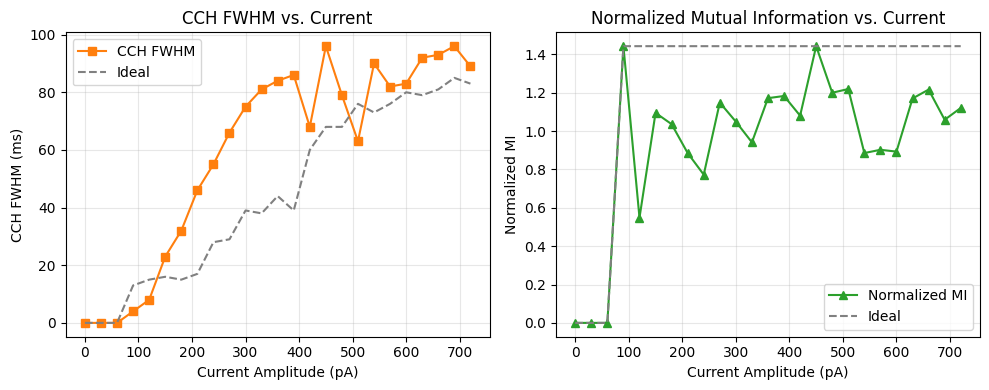


处理电流强度: 0 pA (1/25)

Jul 24 23:47:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:01 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:01 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:01 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:01 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:01 SimulationManager::set_status 

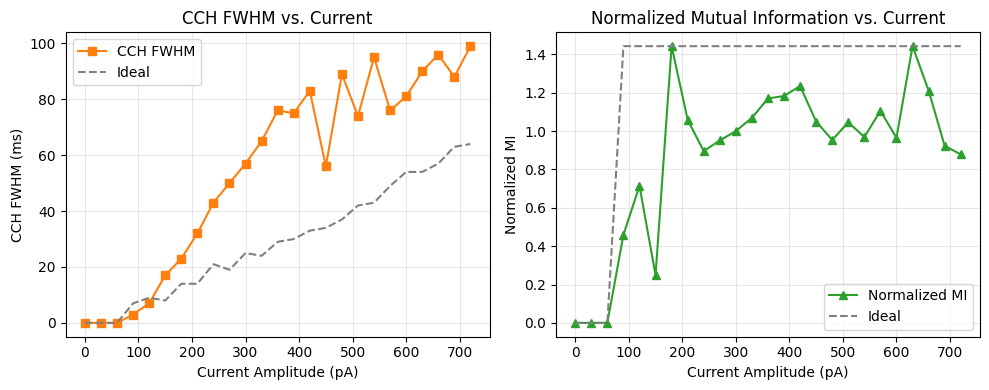


处理电流强度: 0 pA (1/25)

Jul 24 23:47:03 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:03 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:03 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:03 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:03 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:03 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:03 SimulationManager::set_status 

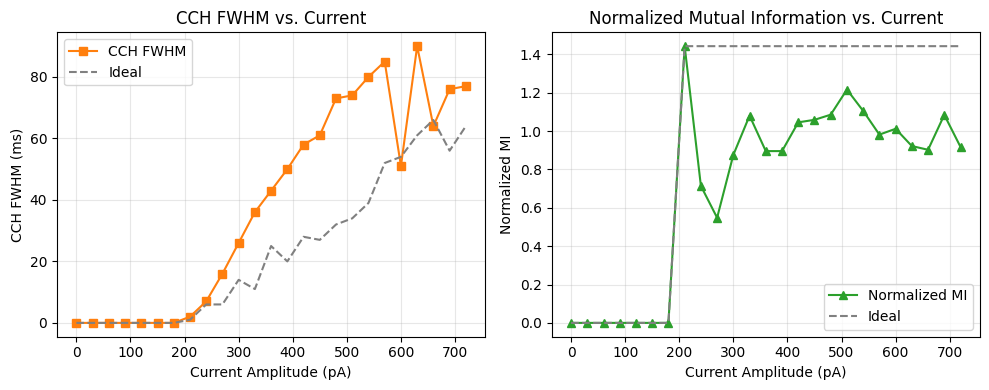


处理电流强度: 0 pA (1/25)

Jul 24 23:47:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:04 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:04 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:04 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:04 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:04 SimulationManager::set_status 

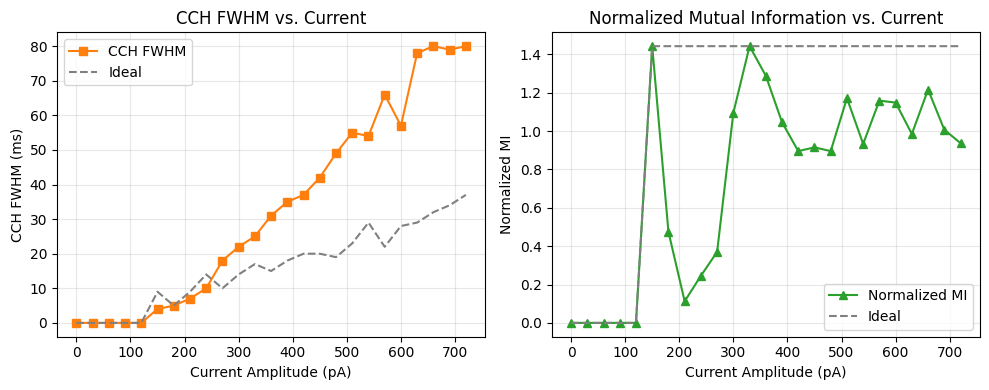


处理电流强度: 0 pA (1/25)

Jul 24 23:47:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:05 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:05 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:05 SimulationManager::set_status 

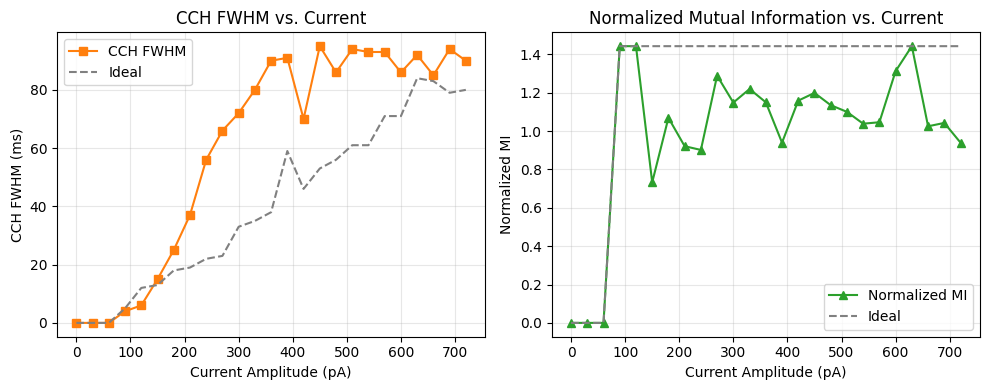


处理电流强度: 0 pA (1/25)

Jul 24 23:47:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:06 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:06 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:06 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:06 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:06 SimulationManager::set_status 

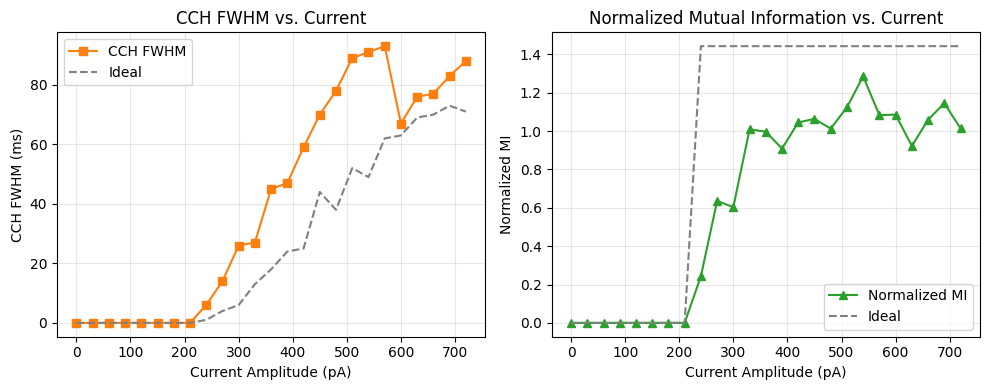


处理电流强度: 0 pA (1/25)

Jul 24 23:47:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:07 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:07 SimulationManager::set_status 

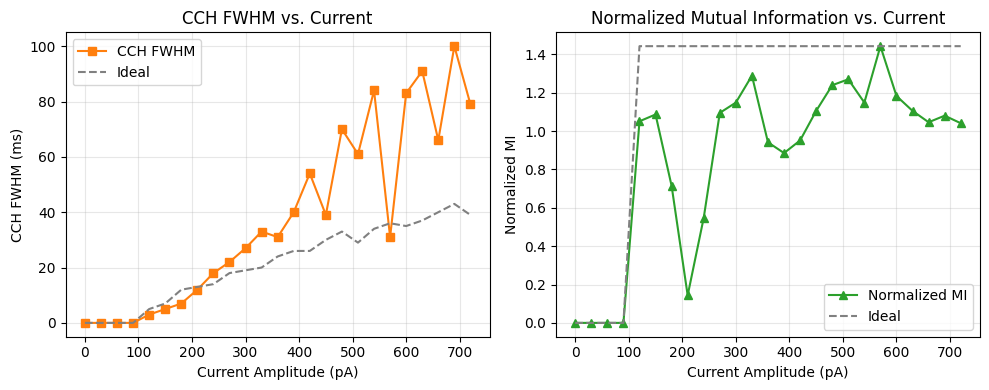


处理电流强度: 0 pA (1/25)

Jul 24 23:47:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:08 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:08 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:08 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:08 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:08 SimulationManager::set_status 

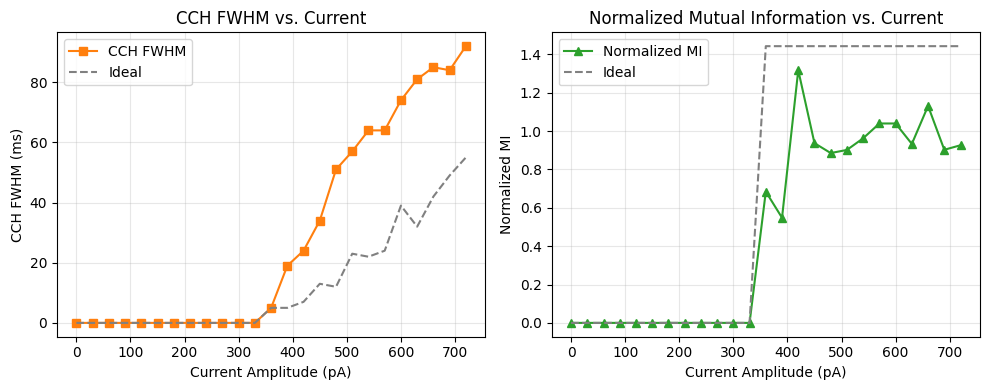


处理电流强度: 0 pA (1/25)

Jul 24 23:47:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:10 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:10 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:10 SimulationManager::set_status 

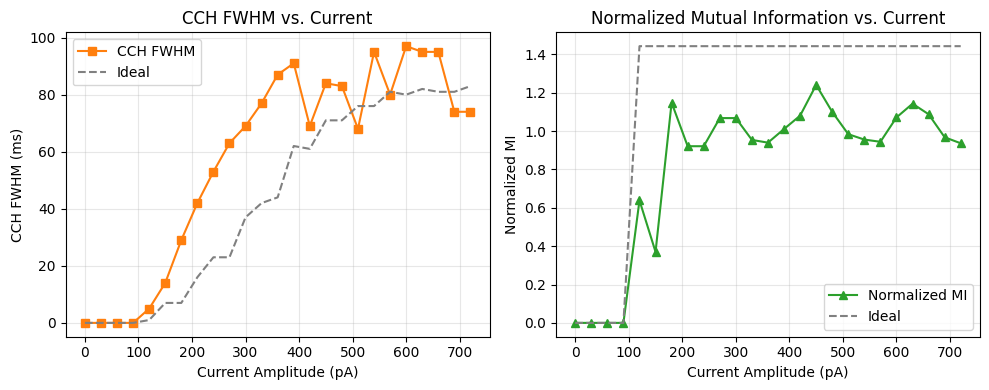


处理电流强度: 0 pA (1/25)

Jul 24 23:47:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:11 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:11 SimulationManager::set_status 

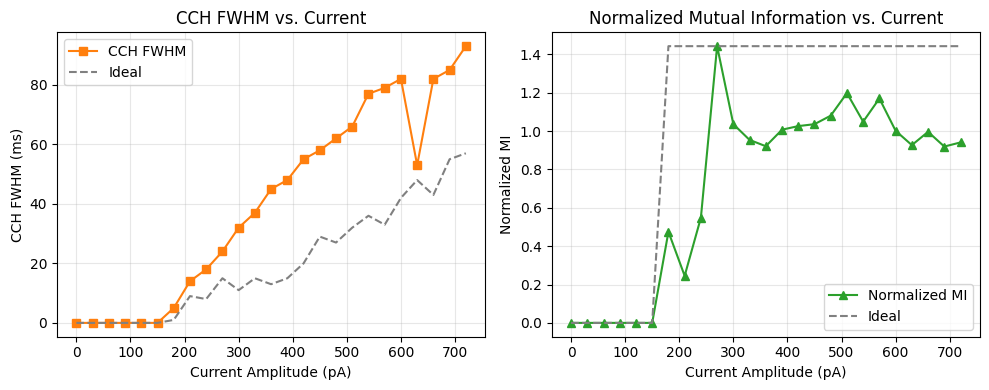


处理电流强度: 0 pA (1/25)

Jul 24 23:47:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:12 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:12 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:12 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:12 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:12 SimulationManager::set_status 

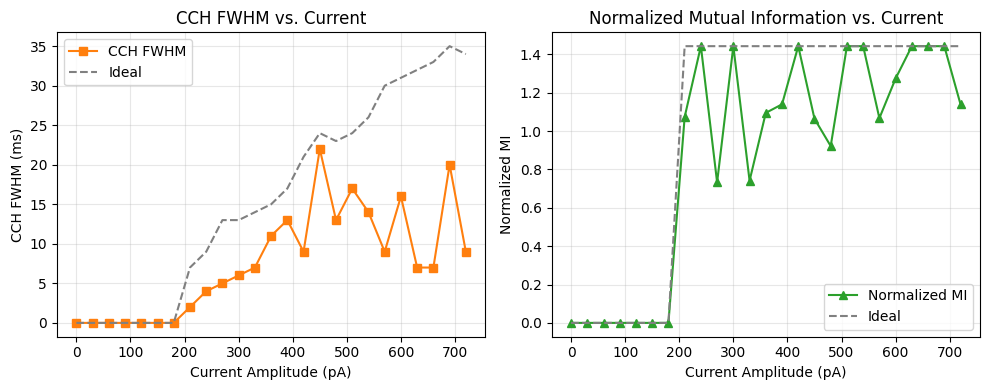


处理电流强度: 0 pA (1/25)

Jul 24 23:47:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:13 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:13 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:13 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:13 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:13 SimulationManager::set_status 

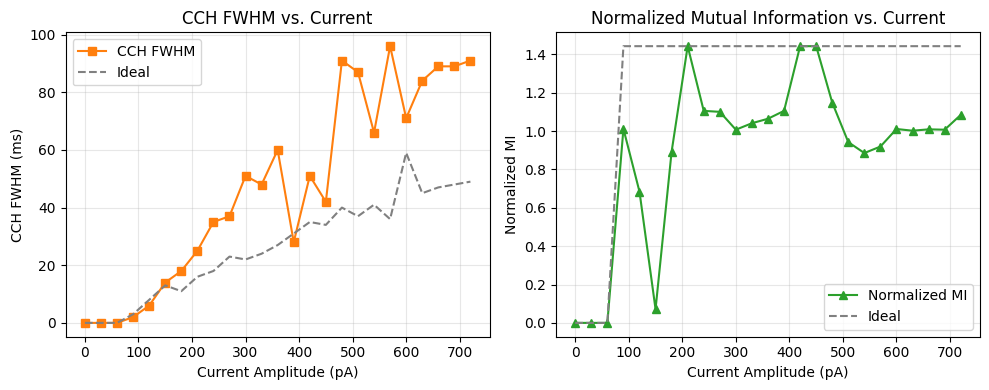


处理电流强度: 0 pA (1/25)

Jul 24 23:47:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:15 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:15 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

处理电流强度: 60 pA (3/25)

Jul 24 23:47:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:15 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:15 SimulationManager::run [Info]: 
    Simulation finished.

Jul 24 23:47:15 SimulationManager::set_status 

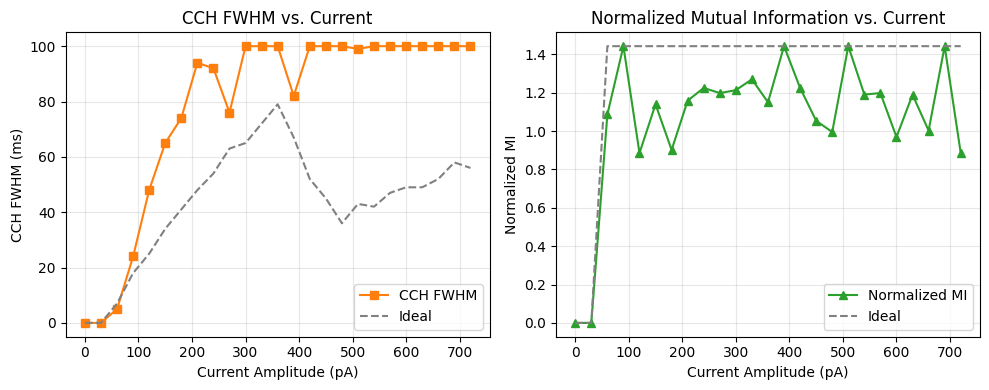


处理电流强度: 0 pA (1/25)

Jul 24 23:47:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:16 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:16 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:16 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:16 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:16 SimulationManager::set_status 

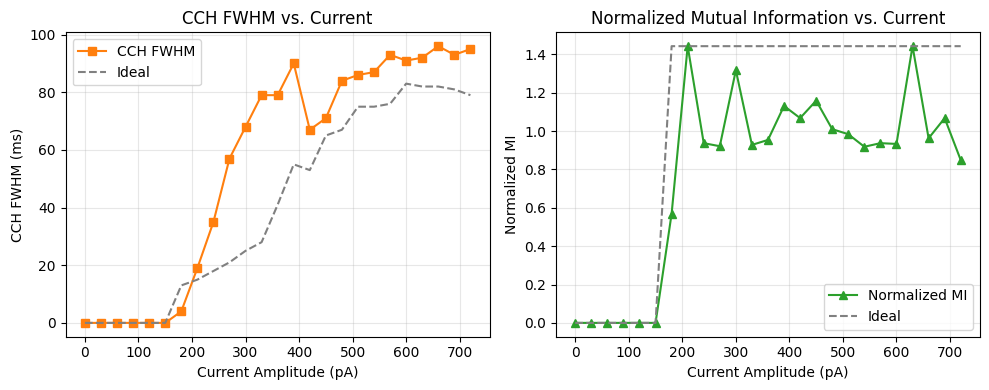


处理电流强度: 0 pA (1/25)

Jul 24 23:47:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:17 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:17 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:17 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:17 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:17 SimulationManager::set_status 

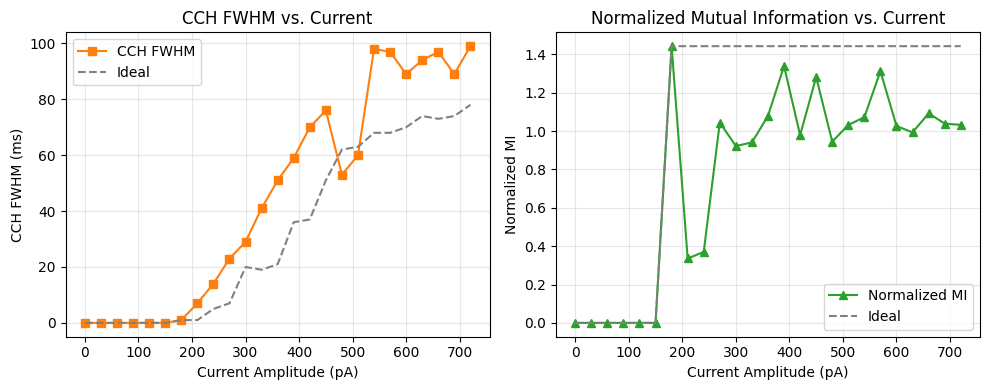


处理电流强度: 0 pA (1/25)

Jul 24 23:47:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:18 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:18 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:18 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:18 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:18 SimulationManager::set_status 

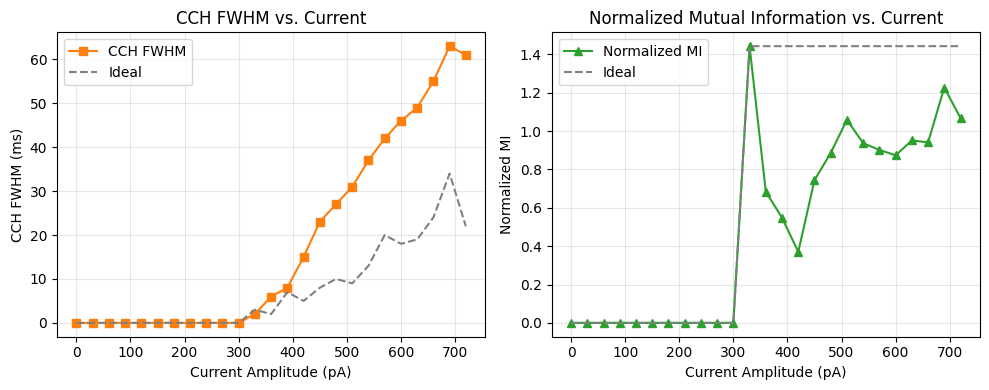


处理电流强度: 0 pA (1/25)

Jul 24 23:47:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:20 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:20 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:20 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:20 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)


处理电流强度: 90 pA (4/25)
Jul 24 23:47:20 Simulati

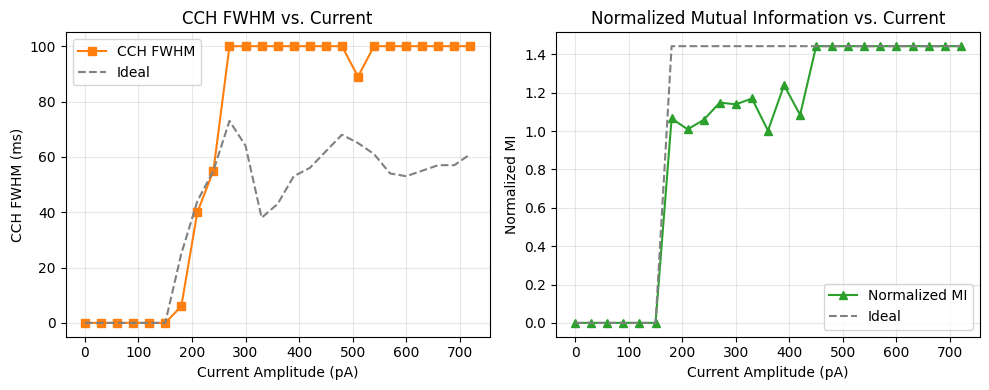


处理电流强度: 0 pA (1/25)

Jul 24 23:47:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:21 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:21 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:21 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:21 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:21 SimulationManager::set_status 

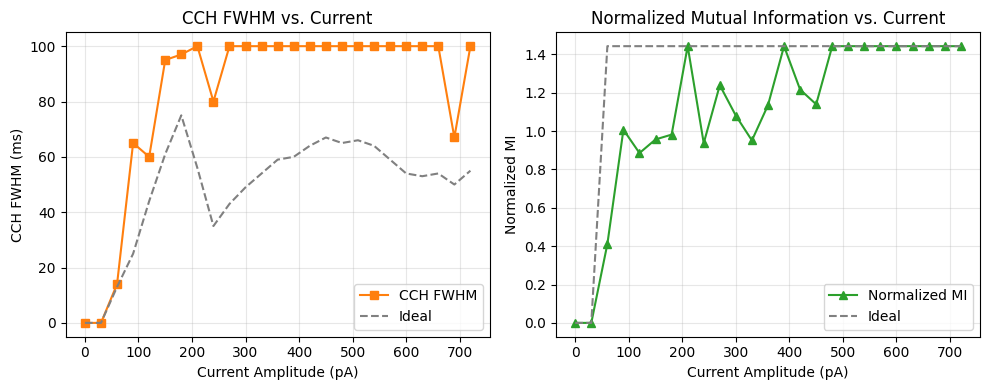


处理电流强度: 0 pA (1/25)

Jul 24 23:47:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:22 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:22 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:22 SimulationManager::set_status 

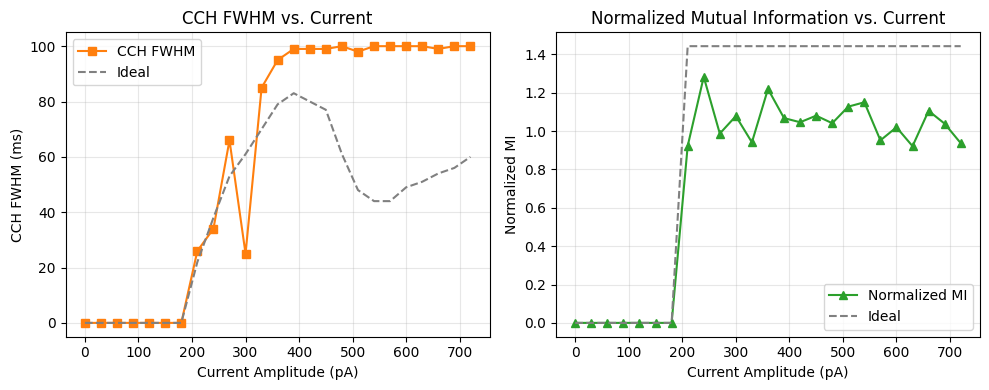


处理电流强度: 0 pA (1/25)

Jul 24 23:47:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:24 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:24 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:24 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:24 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:24 SimulationManager::set_status 

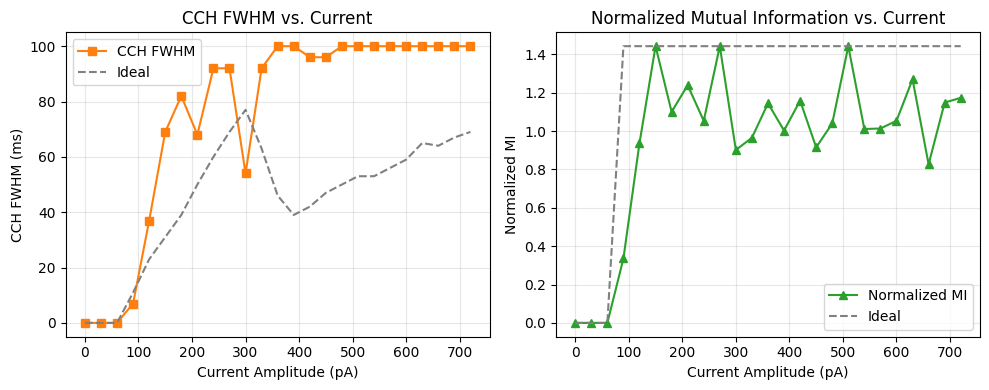


处理电流强度: 0 pA (1/25)

Jul 24 23:47:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:26 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:26 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:26 SimulationManager::set_status 

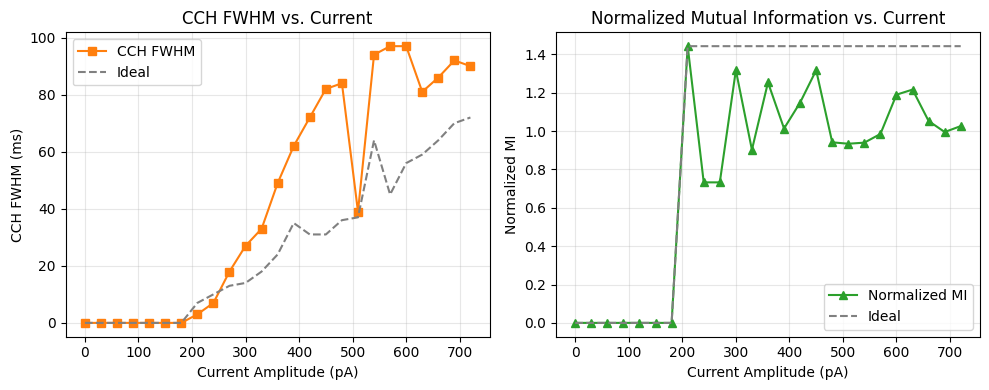


处理电流强度: 0 pA (1/25)

Jul 24 23:47:27 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:27 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:27 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:27 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:27 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:27 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:27 SimulationManager::set_status 

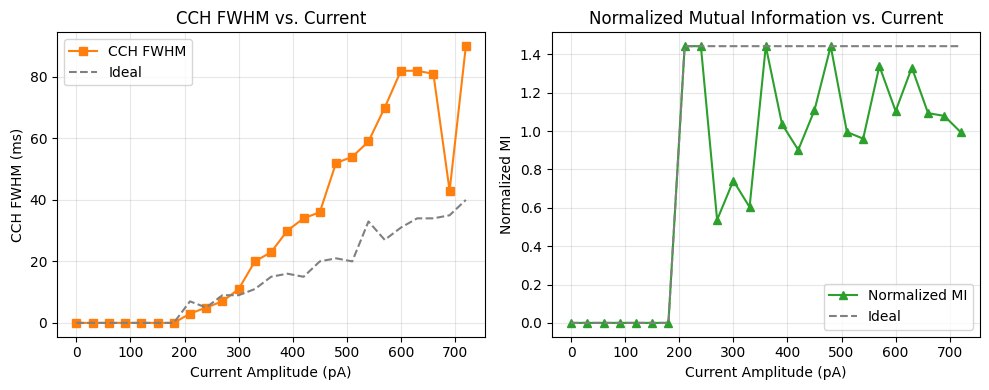


处理电流强度: 0 pA (1/25)

Jul 24 23:47:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:28 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:28 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:28 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:28 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:28 SimulationManager::set_status 

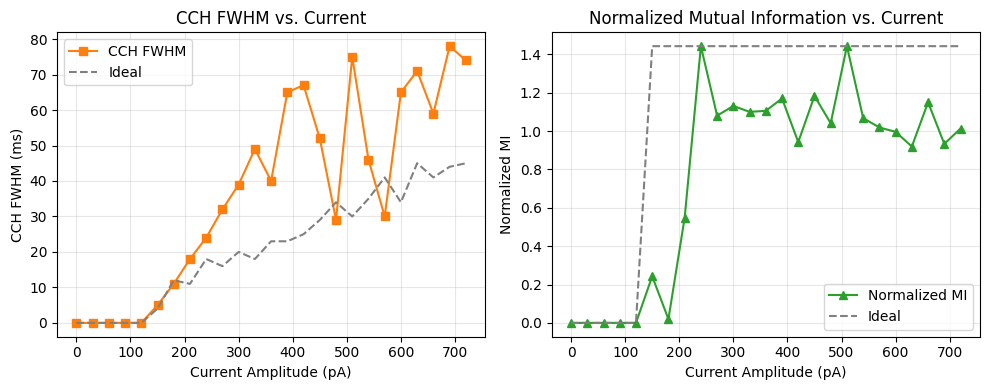


处理电流强度: 0 pA (1/25)

Jul 24 23:47:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:29 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:29 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:29 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:29 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:29 SimulationManager::set_status 

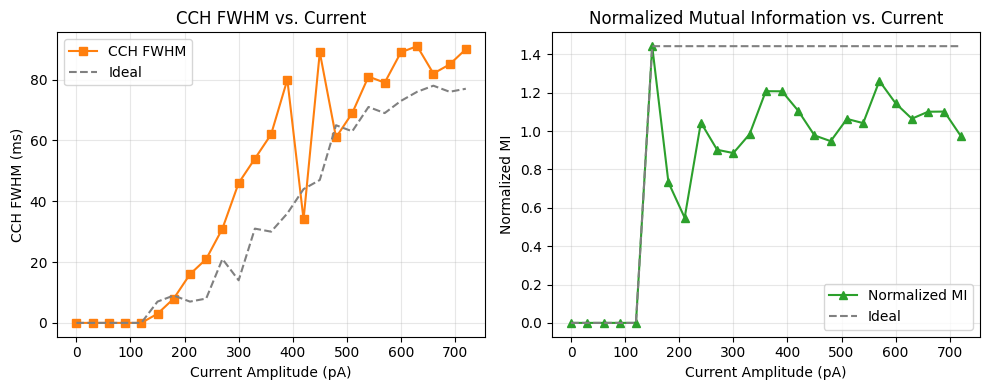


处理电流强度: 0 pA (1/25)

Jul 24 23:47:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:30 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:30 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (2/25)

Jul 24 23:47:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 24 23:47:30 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 24 23:47:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 24 23:47:30 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 60 pA (3/25)

Jul 24 23:47:31 SimulationManager::set_status 

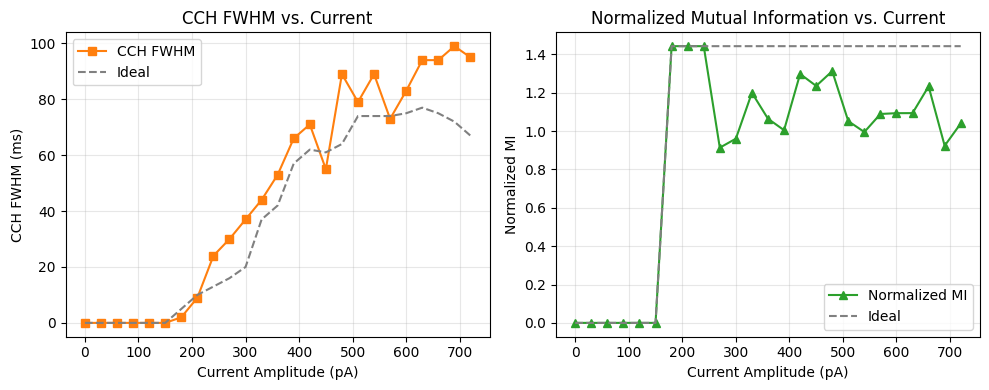

In [ ]:
# 循环测试多个神经元的timing analysis，并保存结果
T = 1000  # ms
current_start = 200
current_end = 800
platform_current = np.arange(0,750,30)

for neuron_model_template_index in range(111):
    Ideal_cch_peak_amplitude_list = []
    Ideal_cch_fwhm_list = []
    Ideal_mi_normalized_list = []
    Ideal_tolerance_2ms_list = []
    Ideal_tolerance_5ms_list = []
    # NEST neuron test
    node_type_id = chen_to_bmtk_mapping[neuron_model_template_index]
    results_nest = analyze_current_response_nest(
        node_type_id=node_type_id,
        dt=0.1,
        current_amplitudes=platform_current,
        T=T, current_start=current_start, current_end=current_end
    )
    sync_analyzer = SpikeTrainSynchronization(dt=0.1)
    for i in range(len(results_nest)):
        results = sync_analyzer.comprehensive_analysis(results_nest[i]['spikes'].reshape(999,10).sum(axis=1), 
                                                    results_nest[i]['spikes'].reshape(999,10).sum(axis=1),
                                                    plot_synchronization=False)
        Ideal_cch_peak_amplitude_list.append(results['cch']['peak_amplitude']) 
        Ideal_cch_fwhm_list.append(results['cch']['fwhm'])
        Ideal_mi_normalized_list.append(results['mutual_information']['mi_normalized'])
        Ideal_tolerance_2ms_list.append(results['coincidence_rate']['tolerance_2ms'][-1])
        Ideal_tolerance_5ms_list.append(results['coincidence_rate']['tolerance_5ms'][-1])

    Ideal_cch_peak_amplitude = np.array(Ideal_cch_peak_amplitude_list)
    Ideal_cch_fwhm = np.array(Ideal_cch_fwhm_list)
    Ideal_mi_normalized = np.array(Ideal_mi_normalized_list)
    Ideal_tolerance_2ms = np.array(Ideal_tolerance_2ms_list)
    Ideal_tolerance_5ms = np.array(Ideal_tolerance_5ms_list)

    # load chen neuron results
    timing_index = np.load('single_neuron_compare/timing_index_'+str(neuron_model_template_index)+'.npy')
    cch_peak_amplitude = timing_index[0]
    cch_fwhm = timing_index[1]
    mi_normalized = timing_index[2]
    tolerance_2ms = timing_index[3]
    tolerance_5ms = timing_index[4]

    plt.figure(figsize=(10,4))
    # 1. CCH FWHM
    plt.subplot(1, 2, 1)
    plt.plot(platform_current, cch_fwhm, 's-', color='tab:orange', label='CCH FWHM')
    plt.plot(platform_current, Ideal_cch_fwhm, '--', color='gray', label='Ideal')
    plt.xlabel('Current Amplitude (pA)')
    plt.ylabel('CCH FWHM (ms)')
    plt.title('CCH FWHM vs. Current')
    plt.grid(True, alpha=0.3)
    plt.legend()
    # 2. Normalized Mutual Information
    plt.subplot(1, 2, 2)
    plt.plot(platform_current, mi_normalized, '^-', color='tab:green', label='Normalized MI')
    plt.plot(platform_current, Ideal_mi_normalized, '--', color='gray', label='Ideal')
    plt.xlabel('Current Amplitude (pA)')
    plt.ylabel('Normalized MI')
    plt.title('Normalized Mutual Information vs. Current')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('single_neuron_compare/timing_'+str(neuron_model_template_index)+'.png')
    plt.show()

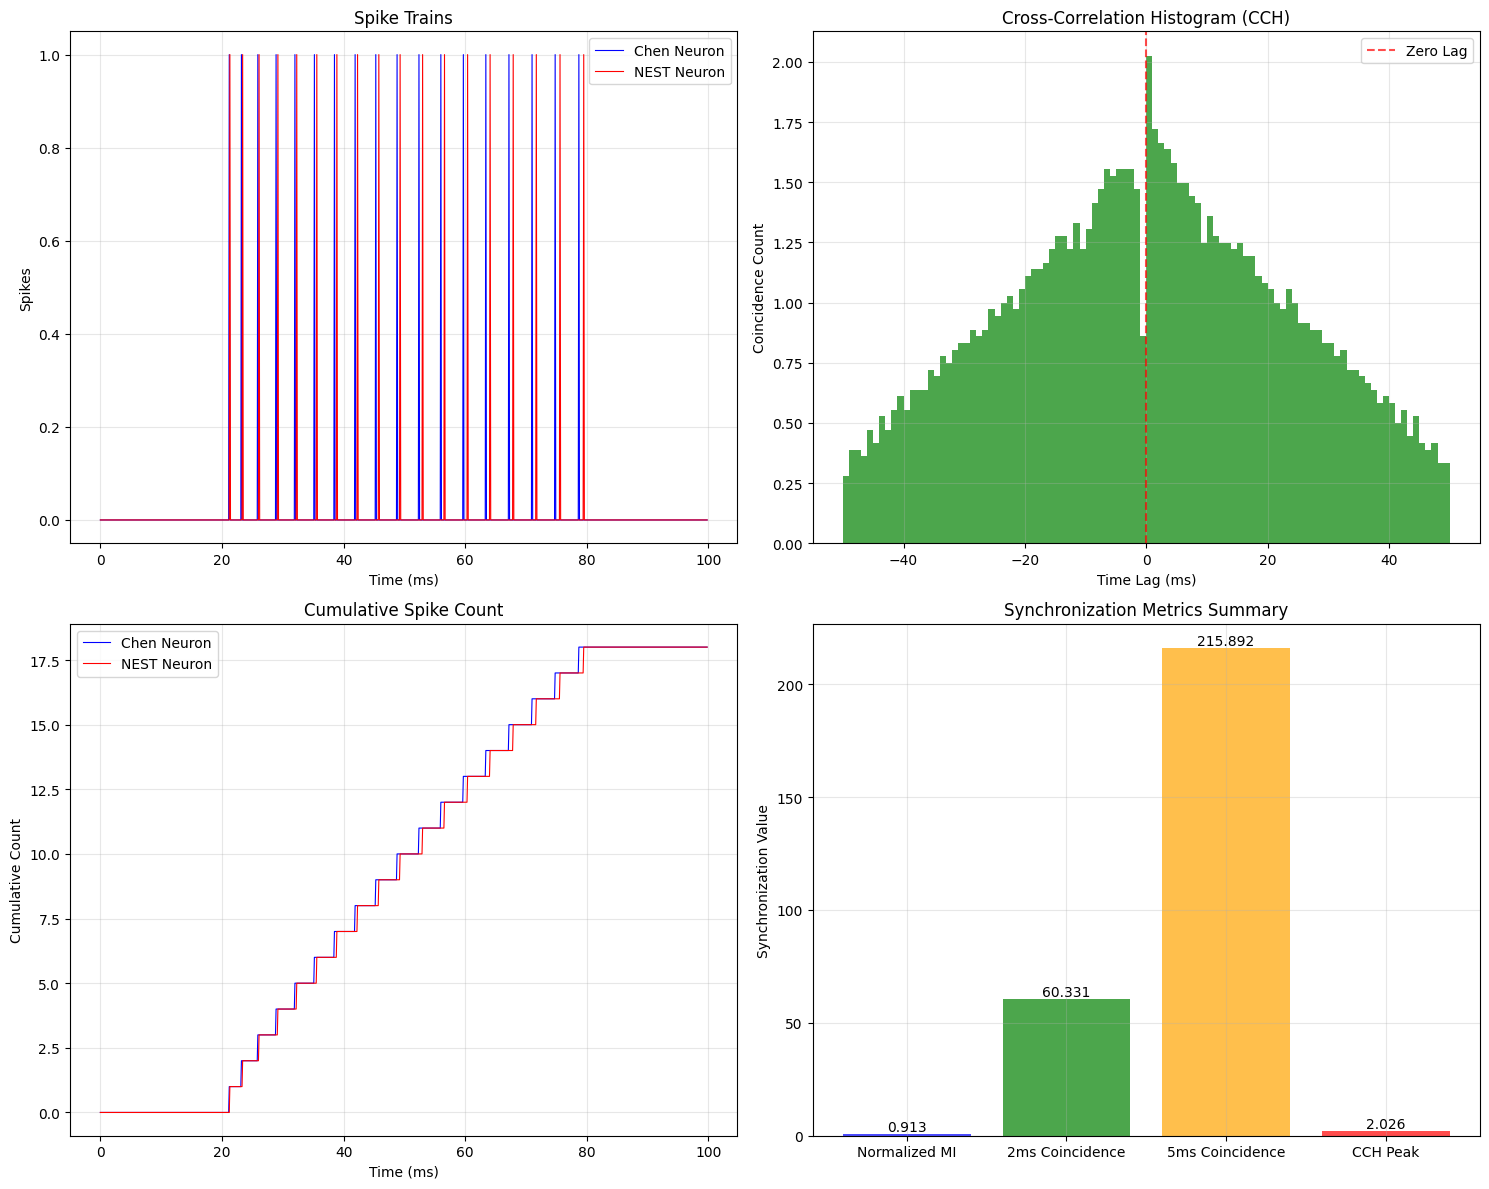

In [19]:
# 单神经元、固定平台电流的可视化样例
T = 1000  # 1000ms
sync_analyzer = SpikeTrainSynchronization(dt=0.1)
sync_analyzer.plot_synchronization_analysis(results_chen[9]['spikes'][:999], 
                                            results_nest[9]['spikes'].reshape(999,10).sum(axis=1),
                                            results['cch']['histogram'], results['cch']['lags'],
                                            neuron_names=["Chen Neuron", "NEST Neuron"])